In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
import torchvision.utils as vutils
import matplotlib.animation as animation
from IPython.display import HTML
import os

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
import copy
import time
import cv2 as cv
from tqdm import tqdm_notebook as tqdm
import matplotlib.image as mpimg

import torchvision.transforms.functional as TF

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
# 1533697a23fb7953f1c0a399557991f3
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: suryapranavannadanam
Your Kaggle Key: ··········


100%|██████████| 8.16G/8.16G [06:49<00:00, 21.4MB/s]


In [ ]:
img_dir = '/content/flickr-image-dataset/flickr30k_images/flickr30k_images/flickr30k_images/'
img_list = os.listdir(img_dir)
print(len(img_list))
valid_ratio = 0.8

31783


In [ ]:
class ImageData(Dataset):
    def __init__(self,is_train=True):
        self.is_train = is_train
        self.transform = transforms.Compose([transforms.ToTensor(),])
        self.train_index = int(valid_ratio * len(img_list))
        self.crop = transforms.CenterCrop((218,178))
    def __len__(self):
        if self.is_train:
            return self.train_index
        else:
            return len(img_list) - self.train_index -1
    def __getitem__(self, index):
        if not self.is_train:
            index = self.train_index + index
        img = mpimg.imread(img_dir+img_list[index])
        img = self.crop(TF.to_pil_image(img))
        img = self.transform(img)
        img = (img-0.5) /0.5
        return img

In [ ]:
batch_size=20
dataset = ImageData()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = 'cuda'

torch.Size([3, 218, 178])


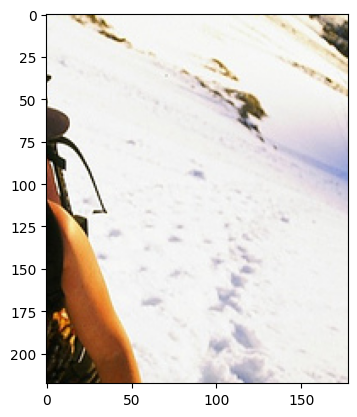

In [ ]:
a = next(iter(dataloader))
print(a[0].shape)
img = a[15]
img = img *0.5 + 0.5
plt.imshow(img.permute(1,2,0))

In [ ]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
IMG_WIDTH = 178
IMG_HEIGHT = 218
latent_size = 200

num_channels_in_encoder = 28

In [ ]:
# Encoder Model
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # ENCODER

        # 64x64x64
        self.e_conv_1 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(5, 5), stride=(2, 2)),nn.LeakyReLU()
        )

        # 128x32x32
        self.e_conv_2 = nn.Sequential(
            nn.ZeroPad2d((1, 2, 1, 2)),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), stride=(2, 2)),
            nn.LeakyReLU()
        )

        # 128x32x32
        self.e_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x32x32
        self.e_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 32x32x32
        self.e_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=num_channels_in_encoder, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
            nn.Tanh()
        )
    def forward(self, x):
        ec1 = self.e_conv_1(x)
        ec2 = self.e_conv_2(ec1)
        eblock1 = self.e_block_1(ec2) + ec2
        eblock2 = self.e_block_2(eblock1) + eblock1
        eblock3 = self.e_block_3(eblock2) + eblock2
        ec3 = self.e_conv_3(eblock3)  # in [-1, 1] from tanh activation
        return ec3

In [ ]:
device

'cuda'

In [ ]:
netE = Encoder().to(device)
netE.apply(weights_init)
inp = torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100)
inp = inp.view((-1,3,IMG_HEIGHT,IMG_WIDTH))
output = netE(inp.to(device))
print(output.shape)
print('The Compression Ratio is :  ' + str((output.shape[1]*output.shape[2]*output.shape[3])/(IMG_WIDTH*IMG_HEIGHT*3)))

torch.Size([100, 28, 54, 44])
The Compression Ratio is :  0.5714874755179878


In [ ]:
# Generator / Decoder Model

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # DECODER

        # 128x64x64
        self.d_up_conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=num_channels_in_encoder, out_channels=64, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 128x64x64
        self.d_block_1 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_2 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 128x64x64
        self.d_block_3 = nn.Sequential(
            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1)),
        )

        # 256x128x128
        self.d_up_conv_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ZeroPad2d((1, 1, 1, 1)),
            nn.ConvTranspose2d(in_channels=32, out_channels=128, kernel_size=(2, 2), stride=(2, 2))
        )

        # 3x128x128
        self.d_up_conv_3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), stride=(1, 1)),
            nn.LeakyReLU(),

            nn.ReflectionPad2d((3, 3, 3, 3)),
            nn.Conv2d(in_channels=16, out_channels=3, kernel_size=(3, 3), stride=(1, 1)),
            nn.Tanh()
        )



    def forward(self, x):
        uc1 = self.d_up_conv_1(x)
        dblock1 = self.d_block_1(uc1) + uc1
        dblock2 = self.d_block_2(dblock1) + dblock1
        dblock3 = self.d_block_3(dblock2) + dblock2
        uc2 = self.d_up_conv_2(dblock3)
        dec = self.d_up_conv_3(uc2)
        return dec

In [ ]:
netG = Generator().to(device)
netG.apply(weights_init)
inp = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44)).to(device)
output = netG(inp)
print(output.shape)
#218 * 178

torch.Size([100, 3, 218, 178])


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.latent_layer1 = nn.Sequential(
            nn.ConvTranspose2d(num_channels_in_encoder, 12, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer2 = nn.Sequential(
            nn.ConvTranspose2d(12, 16, (3,3), stride=1, padding=2, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer3 = nn.Sequential(
            nn.ConvTranspose2d(16, 24, (3,3), stride=2, padding=2, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer4 = nn.Sequential(
            nn.ConvTranspose2d(24, 36, (5,5), stride=2, padding=0, output_padding=1, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
        )
        self.latent_layer5 = nn.Sequential(
            nn.ConvTranspose2d(36, 3, (3,3), stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Tanh(),
        )


        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=64, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5,stride = 2,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=3,stride = 2,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3,stride = 1,padding=2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3,stride = 1,padding=0),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Tanh(),
        )


        self.fc1 = nn.Sequential(
            nn.Linear(8*54*44,2000),
            nn.Sigmoid(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(2000,100),
            nn.Sigmoid(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(100,1),
            nn.Sigmoid(),
        )


    def forward(self, x):
        y = x['encoded'].to(device)
        y = self.latent_layer1(y)
        y = self.latent_layer2(y)
        y = self.latent_layer3(y)
        y = self.latent_layer4(y)
        y = self.latent_layer5(y)
#         print(y.shape)
        x = x['img'].to(device)
#         print(x.shape)
        x = torch.cat((x,y),1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
#         print(x.shape)
        x= x.reshape((x.shape[0],-1))
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
netD = Discriminator().to(device)
netD.apply(weights_init)
inp_x = {}
inp_x['img']=torch.randn(IMG_WIDTH*IMG_HEIGHT*3 * 100).view((-1,3,IMG_HEIGHT,IMG_WIDTH))
inp_x['encoded'] = torch.randn(100*num_channels_in_encoder*54*44).view((-1,num_channels_in_encoder,54,44))
output = netD(inp_x)
output.shape

torch.Size([100, 1])

In [ ]:
lr = 0.0002
# Initialize BCELoss function
criterion = nn.BCELoss()
msecriterion = nn.MSELoss()
l1criterion = nn.L1Loss()
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerE = optim.Adam(netE.parameters(), lr=lr, betas=(0.5, 0.999))

In [ ]:
valid_dataset = ImageData(is_train=False)
num_images_to_show = 1
valid_dataloader = DataLoader(valid_dataset, batch_size=num_images_to_show, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

Starting Training Loop...
[0/7][0/1272]	Loss_D: 1.3986	Loss_G: 2.8520	Loss_E: 2.8534	D(x): 0.5621	D(G(z)): 0.5621 / 0.4804


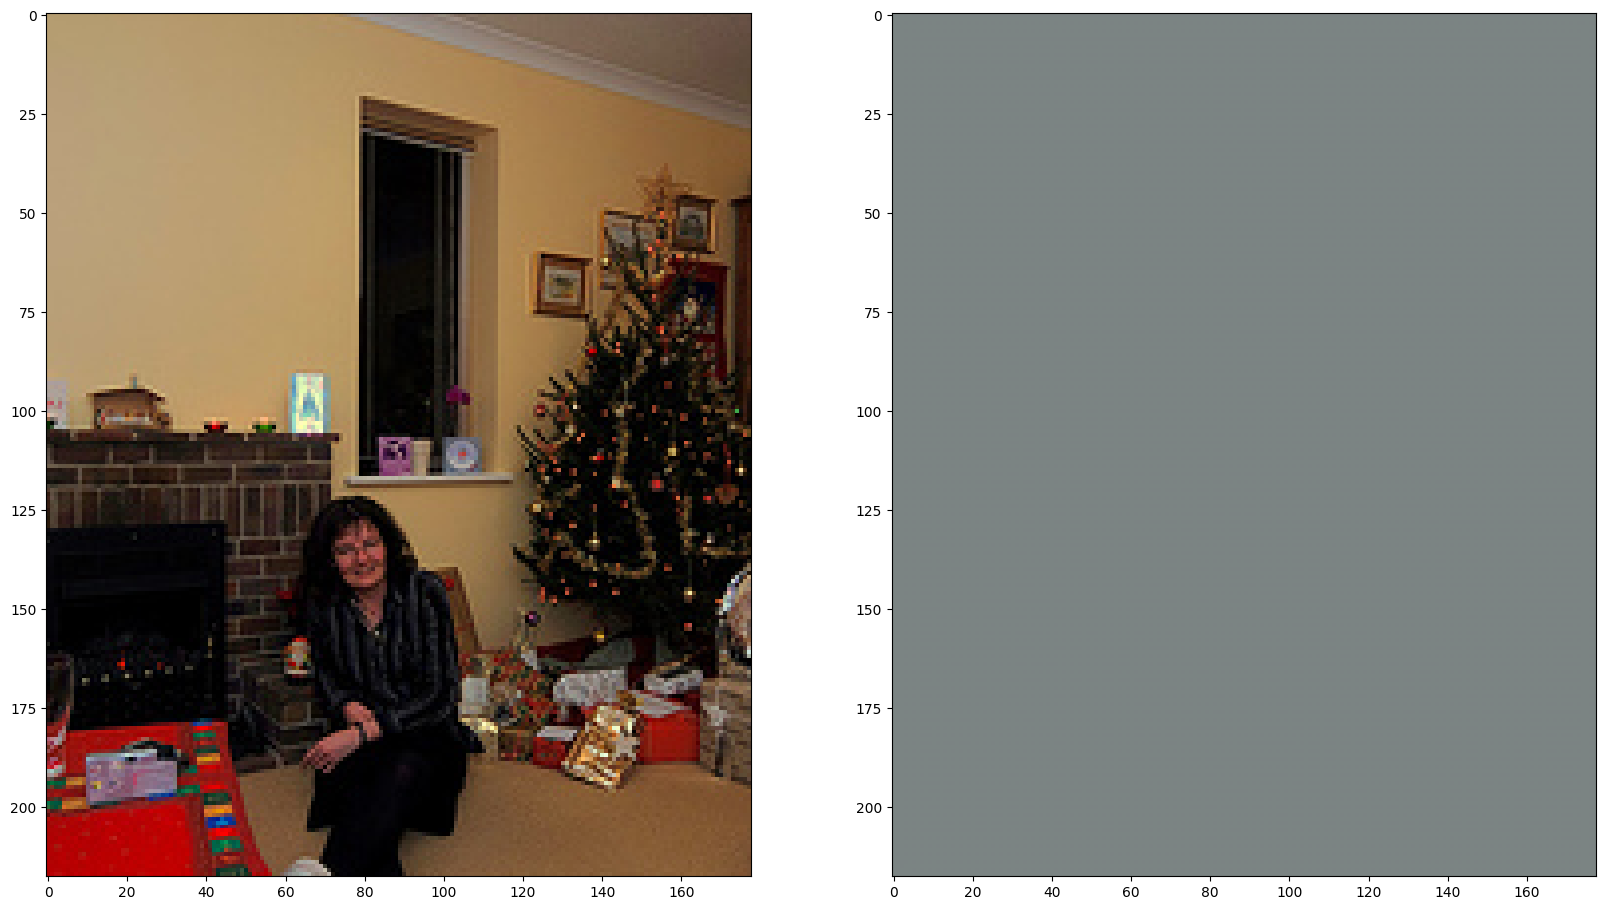

[0/7][50/1272]	Loss_D: 1.3494	Loss_G: 1.7101	Loss_E: 1.7138	D(x): 0.6557	D(G(z)): 0.5931 / 0.4592
[0/7][100/1272]	Loss_D: 1.3354	Loss_G: 1.7292	Loss_E: 1.7258	D(x): 0.5147	D(G(z)): 0.4799 / 0.4686
[0/7][150/1272]	Loss_D: 1.0199	Loss_G: 2.3607	Loss_E: 2.3604	D(x): 0.6250	D(G(z)): 0.3499 / 0.3070
[0/7][200/1272]	Loss_D: 1.3935	Loss_G: 1.7778	Loss_E: 1.7781	D(x): 0.5013	D(G(z)): 0.5044 / 0.5030
[0/7][250/1272]	Loss_D: 1.2840	Loss_G: 1.7167	Loss_E: 1.7175	D(x): 0.5208	D(G(z)): 0.4546 / 0.4440
[0/7][300/1272]	Loss_D: 1.3835	Loss_G: 1.6628	Loss_E: 1.6623	D(x): 0.5047	D(G(z)): 0.5029 / 0.5039
[0/7][350/1272]	Loss_D: 1.0886	Loss_G: 3.9670	Loss_E: 3.9574	D(x): 0.6576	D(G(z)): 0.3468 / 0.2570
[0/7][400/1272]	Loss_D: 1.3901	Loss_G: 1.9019	Loss_E: 1.9024	D(x): 0.5165	D(G(z)): 0.5181 / 0.5078
[0/7][450/1272]	Loss_D: 1.3728	Loss_G: 1.7049	Loss_E: 1.7082	D(x): 0.5012	D(G(z)): 0.4930 / 0.4935
[0/7][500/1272]	Loss_D: 1.3721	Loss_G: 1.6132	Loss_E: 1.6148	D(x): 0.5032	D(G(z)): 0.4913 / 0.4949


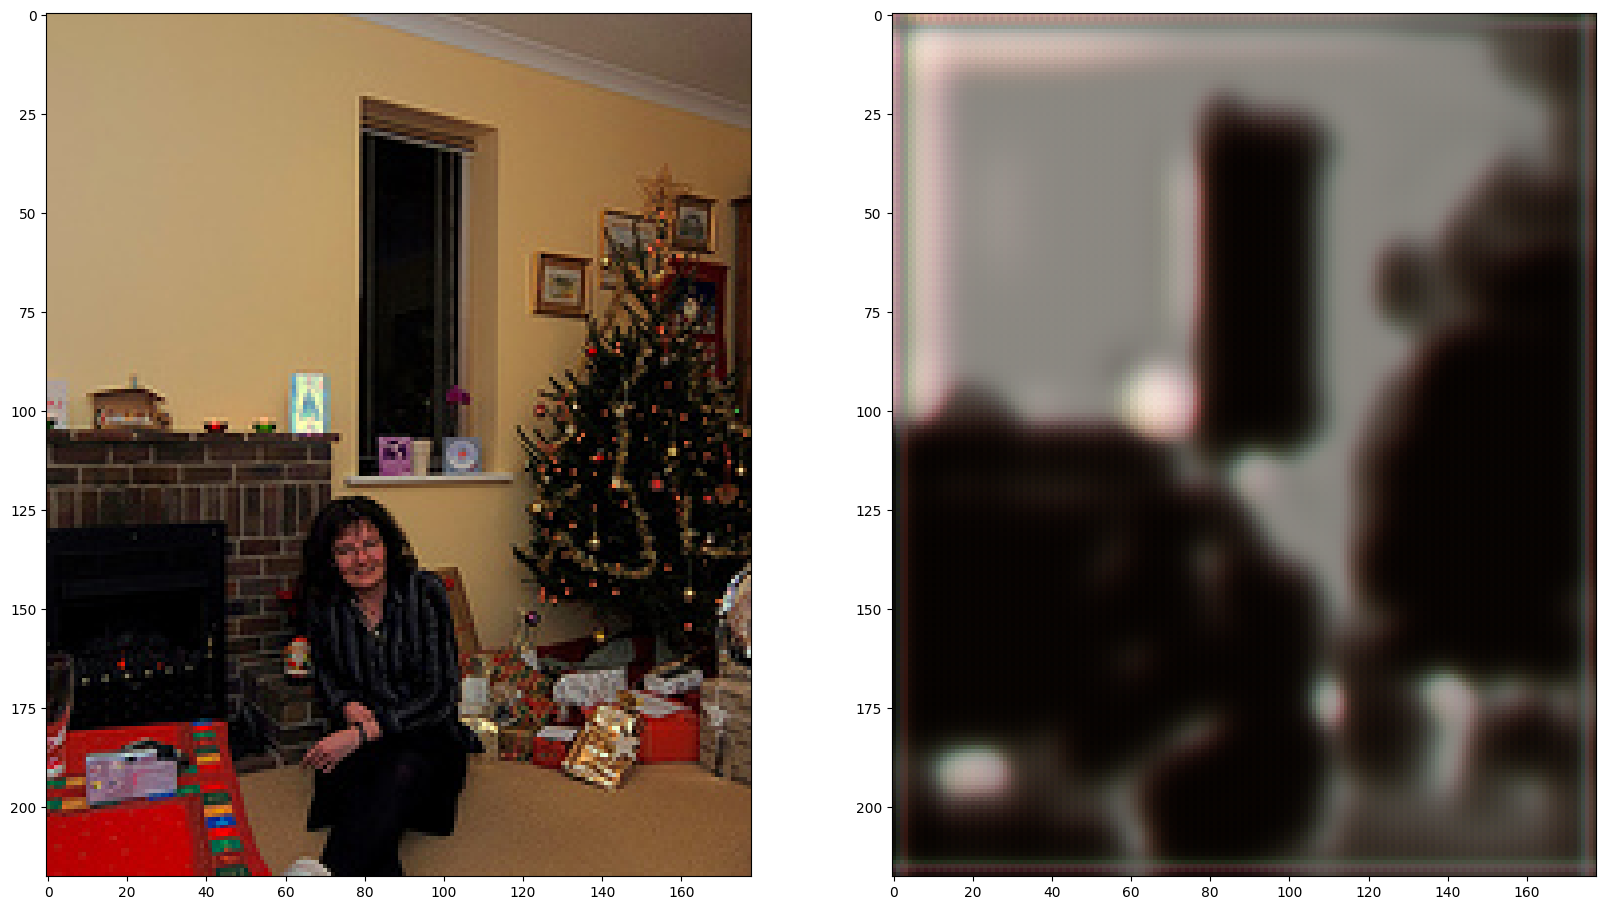

[0/7][550/1272]	Loss_D: 1.3677	Loss_G: 1.6156	Loss_E: 1.6130	D(x): 0.5012	D(G(z)): 0.4871 / 0.4965
[0/7][600/1272]	Loss_D: 1.3762	Loss_G: 1.6143	Loss_E: 1.6135	D(x): 0.5185	D(G(z)): 0.5113 / 0.4998
[0/7][650/1272]	Loss_D: 1.3338	Loss_G: 1.5889	Loss_E: 1.5891	D(x): 0.4821	D(G(z)): 0.4372 / 0.4690
[0/7][700/1272]	Loss_D: 1.2236	Loss_G: 1.8202	Loss_E: 1.8314	D(x): 0.5195	D(G(z)): 0.4130 / 0.4578
[0/7][750/1272]	Loss_D: 1.0185	Loss_G: 2.3281	Loss_E: 2.3426	D(x): 0.6341	D(G(z)): 0.3375 / 0.2546
[0/7][800/1272]	Loss_D: 1.3606	Loss_G: 1.4127	Loss_E: 1.4134	D(x): 0.5172	D(G(z)): 0.5016 / 0.5029
[0/7][850/1272]	Loss_D: 1.3038	Loss_G: 1.6006	Loss_E: 1.6046	D(x): 0.5470	D(G(z)): 0.4923 / 0.4578
[0/7][900/1272]	Loss_D: 1.3284	Loss_G: 1.6861	Loss_E: 1.6855	D(x): 0.5296	D(G(z)): 0.4941 / 0.4611
[0/7][950/1272]	Loss_D: 1.2773	Loss_G: 1.7474	Loss_E: 1.7413	D(x): 0.5226	D(G(z)): 0.4429 / 0.4089
[0/7][1000/1272]	Loss_D: 1.2539	Loss_G: 1.7769	Loss_E: 1.7814	D(x): 0.5650	D(G(z)): 0.4708 / 0.4477


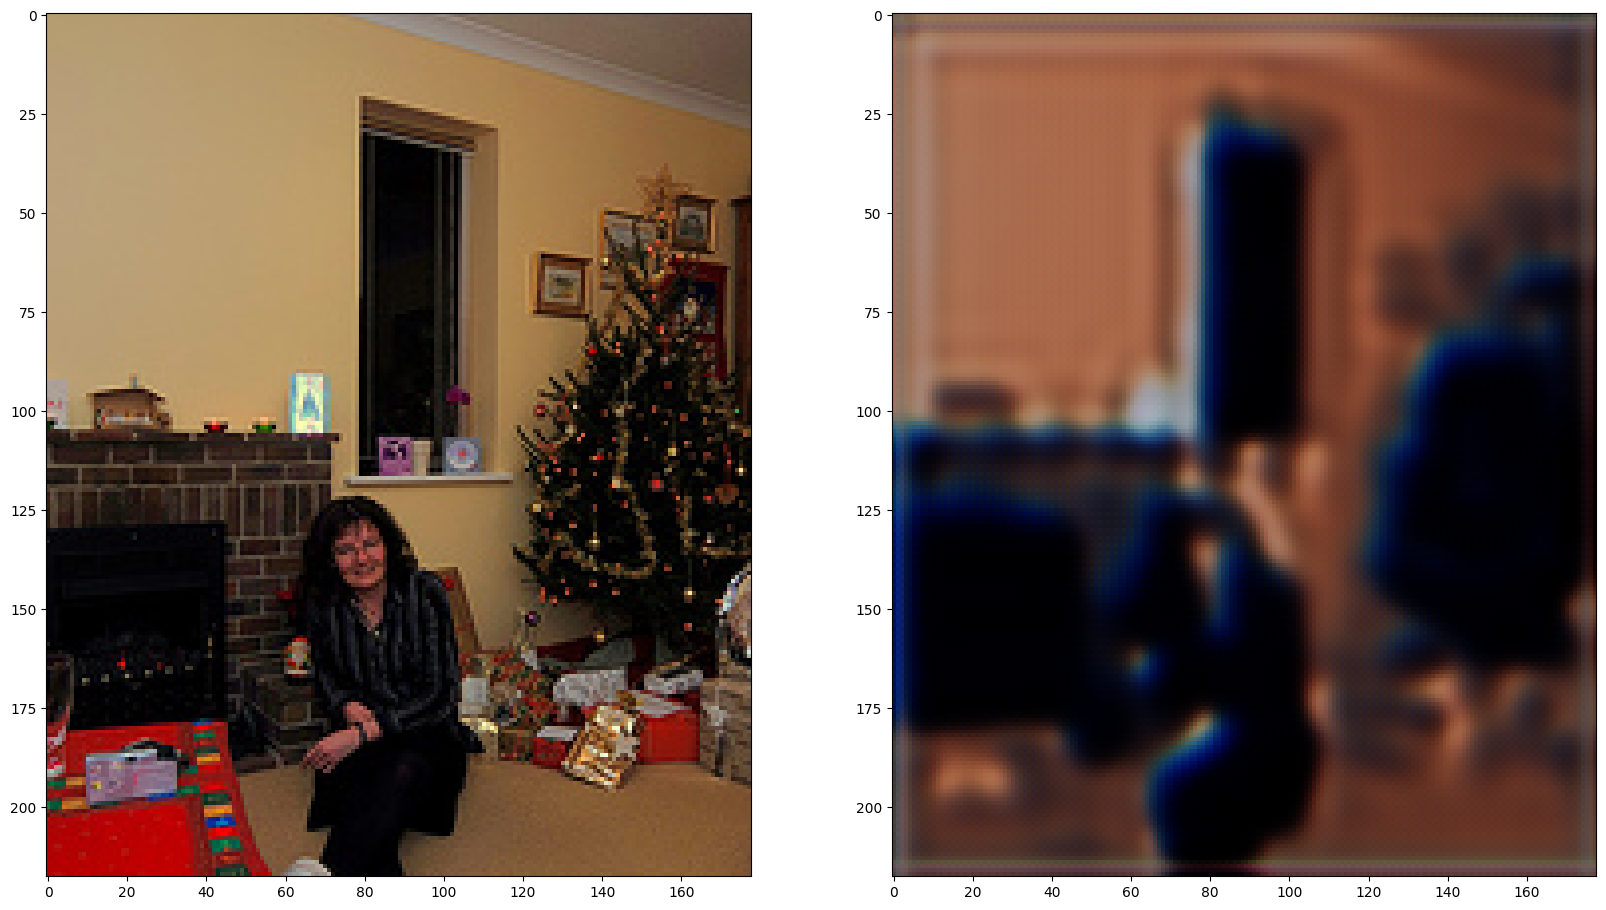

[0/7][1050/1272]	Loss_D: 1.3698	Loss_G: 1.8186	Loss_E: 1.8203	D(x): 0.4697	D(G(z)): 0.4266 / 0.4769
[0/7][1100/1272]	Loss_D: 1.3558	Loss_G: 1.5872	Loss_E: 1.5864	D(x): 0.4949	D(G(z)): 0.4707 / 0.4587
[0/7][1150/1272]	Loss_D: 1.3798	Loss_G: 2.0723	Loss_E: 2.0767	D(x): 0.6174	D(G(z)): 0.5752 / 0.3287
[0/7][1200/1272]	Loss_D: 1.3411	Loss_G: 1.9996	Loss_E: 2.0074	D(x): 0.4841	D(G(z)): 0.3911 / 0.3842
[0/7][1250/1272]	Loss_D: 1.2337	Loss_G: 1.7219	Loss_E: 1.7244	D(x): 0.5716	D(G(z)): 0.4568 / 0.4449
[1/7][0/1272]	Loss_D: 1.4591	Loss_G: 1.9227	Loss_E: 1.9310	D(x): 0.4830	D(G(z)): 0.5109 / 0.5033


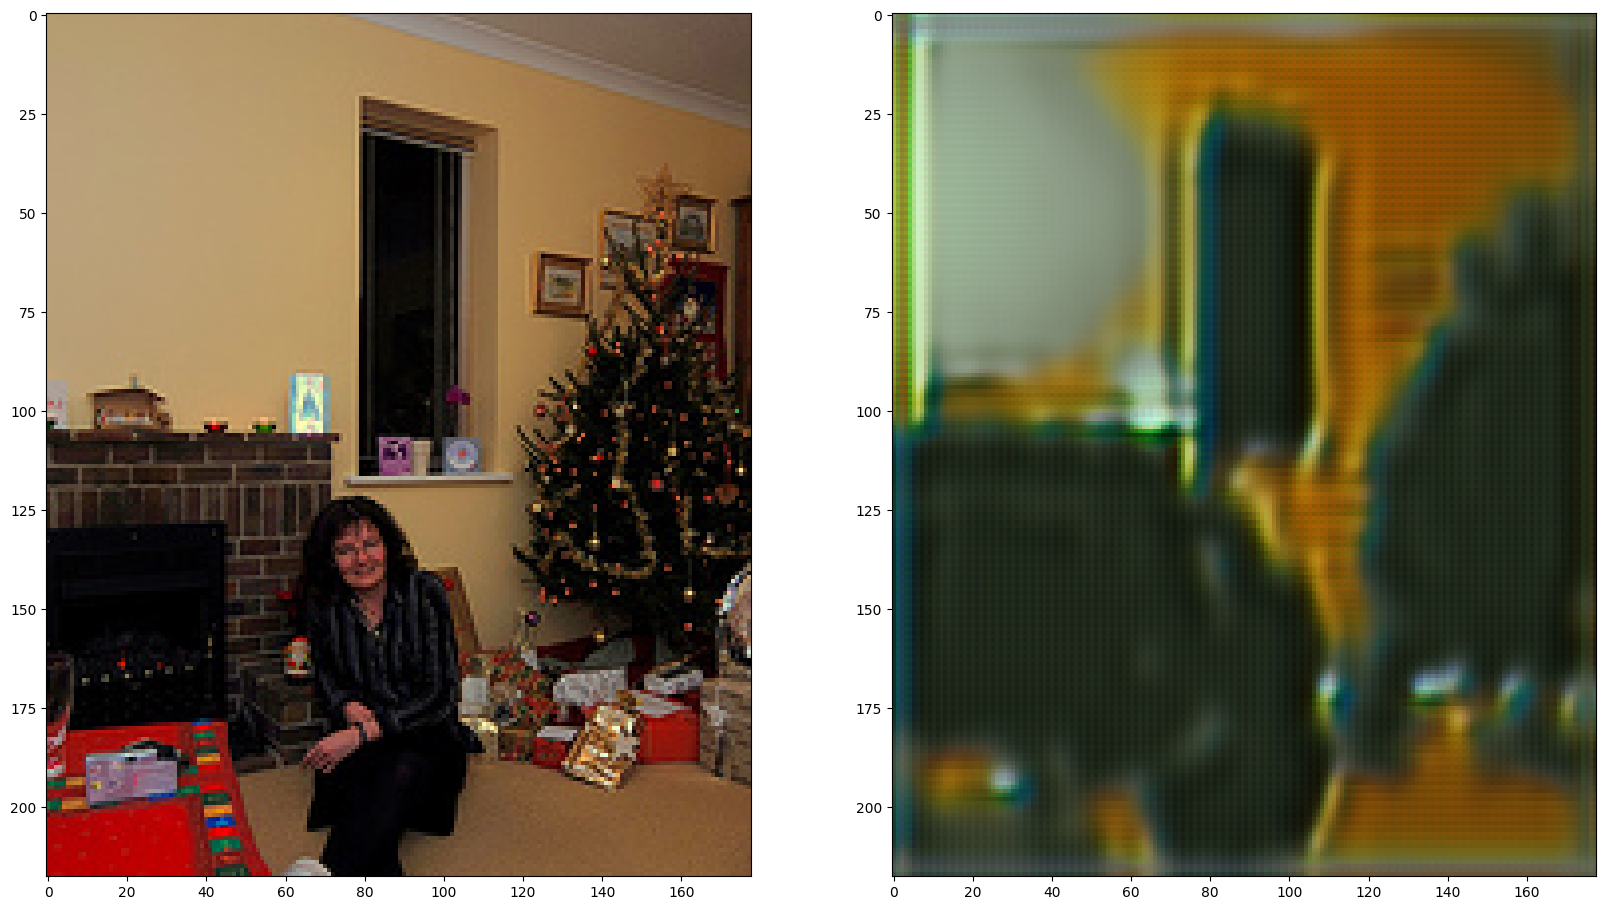

[1/7][50/1272]	Loss_D: 1.3296	Loss_G: 1.7032	Loss_E: 1.7006	D(x): 0.4952	D(G(z)): 0.4529 / 0.4353
[1/7][100/1272]	Loss_D: 1.3205	Loss_G: 1.6616	Loss_E: 1.6587	D(x): 0.5147	D(G(z)): 0.4682 / 0.4377
[1/7][150/1272]	Loss_D: 1.3543	Loss_G: 1.5447	Loss_E: 1.5408	D(x): 0.4556	D(G(z)): 0.4260 / 0.4720
[1/7][200/1272]	Loss_D: 1.3923	Loss_G: 1.7080	Loss_E: 1.7143	D(x): 0.5159	D(G(z)): 0.5021 / 0.4394
[1/7][250/1272]	Loss_D: 1.3797	Loss_G: 1.6146	Loss_E: 1.6164	D(x): 0.4532	D(G(z)): 0.4401 / 0.4469
[1/7][300/1272]	Loss_D: 1.3855	Loss_G: 1.6439	Loss_E: 1.6488	D(x): 0.4443	D(G(z)): 0.4268 / 0.4095
[1/7][350/1272]	Loss_D: 1.3505	Loss_G: 1.3487	Loss_E: 1.3442	D(x): 0.4907	D(G(z)): 0.4601 / 0.4676
[1/7][400/1272]	Loss_D: 1.3952	Loss_G: 1.6232	Loss_E: 1.6184	D(x): 0.4502	D(G(z)): 0.4396 / 0.4400
[1/7][450/1272]	Loss_D: 1.3581	Loss_G: 1.4231	Loss_E: 1.4165	D(x): 0.5103	D(G(z)): 0.4796 / 0.4860
[1/7][500/1272]	Loss_D: 1.3374	Loss_G: 1.5070	Loss_E: 1.5087	D(x): 0.5428	D(G(z)): 0.5023 / 0.4739


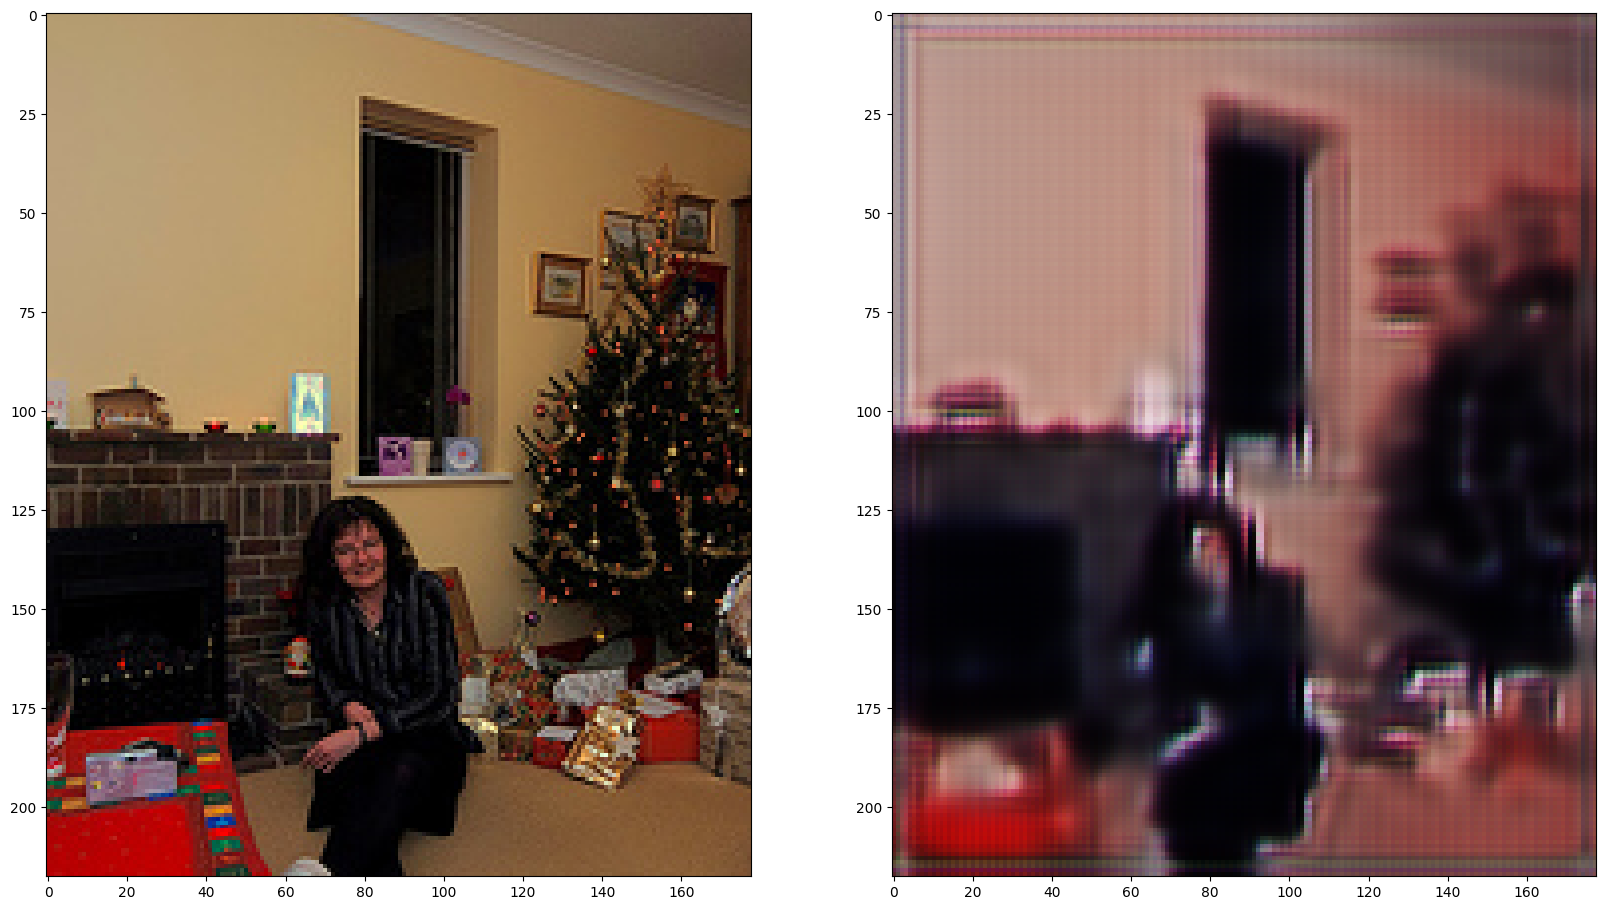

[1/7][550/1272]	Loss_D: 1.2207	Loss_G: 1.3069	Loss_E: 1.3057	D(x): 0.5808	D(G(z)): 0.4644 / 0.4653
[1/7][600/1272]	Loss_D: 1.4181	Loss_G: 1.6612	Loss_E: 1.6607	D(x): 0.6280	D(G(z)): 0.6034 / 0.4362
[1/7][650/1272]	Loss_D: 1.4246	Loss_G: 1.4155	Loss_E: 1.4130	D(x): 0.4458	D(G(z)): 0.4484 / 0.4597
[1/7][700/1272]	Loss_D: 1.4235	Loss_G: 1.5946	Loss_E: 1.5907	D(x): 0.4164	D(G(z)): 0.4175 / 0.4429
[1/7][750/1272]	Loss_D: 1.3780	Loss_G: 1.3132	Loss_E: 1.3118	D(x): 0.4687	D(G(z)): 0.4550 / 0.4619
[1/7][800/1272]	Loss_D: 1.3327	Loss_G: 1.4558	Loss_E: 1.4575	D(x): 0.4911	D(G(z)): 0.4439 / 0.4445
[1/7][850/1272]	Loss_D: 1.1997	Loss_G: 1.4776	Loss_E: 1.4705	D(x): 0.5711	D(G(z)): 0.4333 / 0.4882
[1/7][900/1272]	Loss_D: 1.3564	Loss_G: 1.4173	Loss_E: 1.4150	D(x): 0.5016	D(G(z)): 0.4763 / 0.4621
[1/7][950/1272]	Loss_D: 1.3772	Loss_G: 1.5982	Loss_E: 1.6036	D(x): 0.4449	D(G(z)): 0.4269 / 0.4218
[1/7][1000/1272]	Loss_D: 1.2178	Loss_G: 1.3290	Loss_E: 1.3300	D(x): 0.6037	D(G(z)): 0.4785 / 0.5236


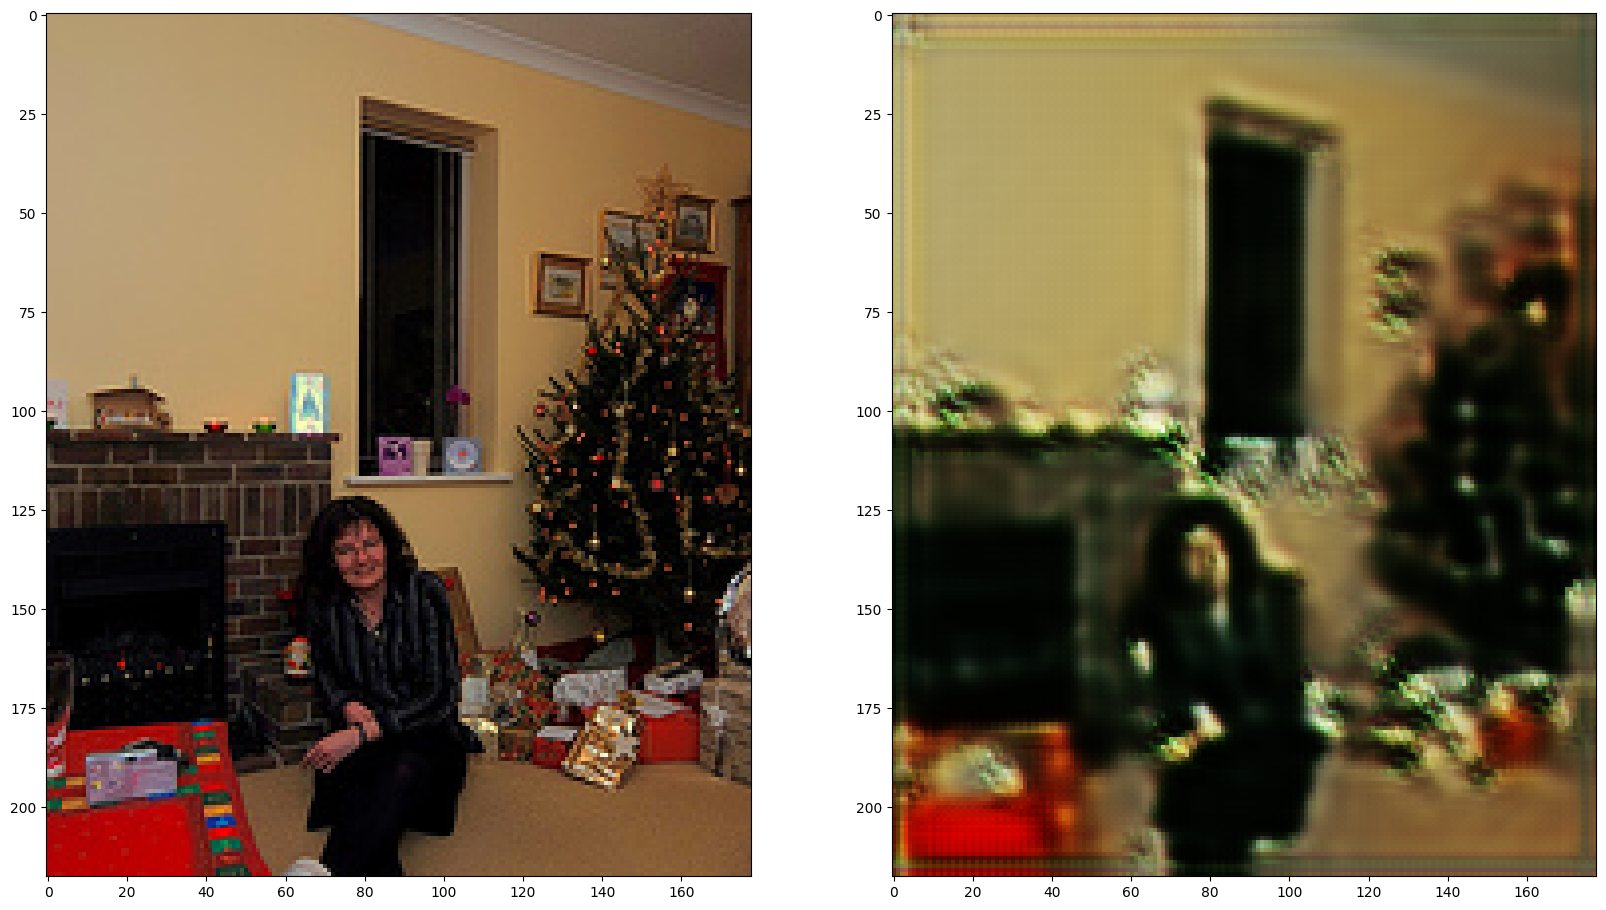

[1/7][1050/1272]	Loss_D: 1.4136	Loss_G: 1.3371	Loss_E: 1.3378	D(x): 0.4218	D(G(z)): 0.4211 / 0.4263
[1/7][1100/1272]	Loss_D: 1.4082	Loss_G: 1.4842	Loss_E: 1.4856	D(x): 0.4745	D(G(z)): 0.4736 / 0.4688
[1/7][1150/1272]	Loss_D: 1.2583	Loss_G: 1.3423	Loss_E: 1.3439	D(x): 0.5243	D(G(z)): 0.4271 / 0.4297
[1/7][1200/1272]	Loss_D: 1.3693	Loss_G: 1.4072	Loss_E: 1.4051	D(x): 0.4372	D(G(z)): 0.4155 / 0.4180
[1/7][1250/1272]	Loss_D: 1.4055	Loss_G: 1.4808	Loss_E: 1.4831	D(x): 0.4243	D(G(z)): 0.4017 / 0.4069
[2/7][0/1272]	Loss_D: 1.3427	Loss_G: 1.5085	Loss_E: 1.5065	D(x): 0.5208	D(G(z)): 0.4895 / 0.4757


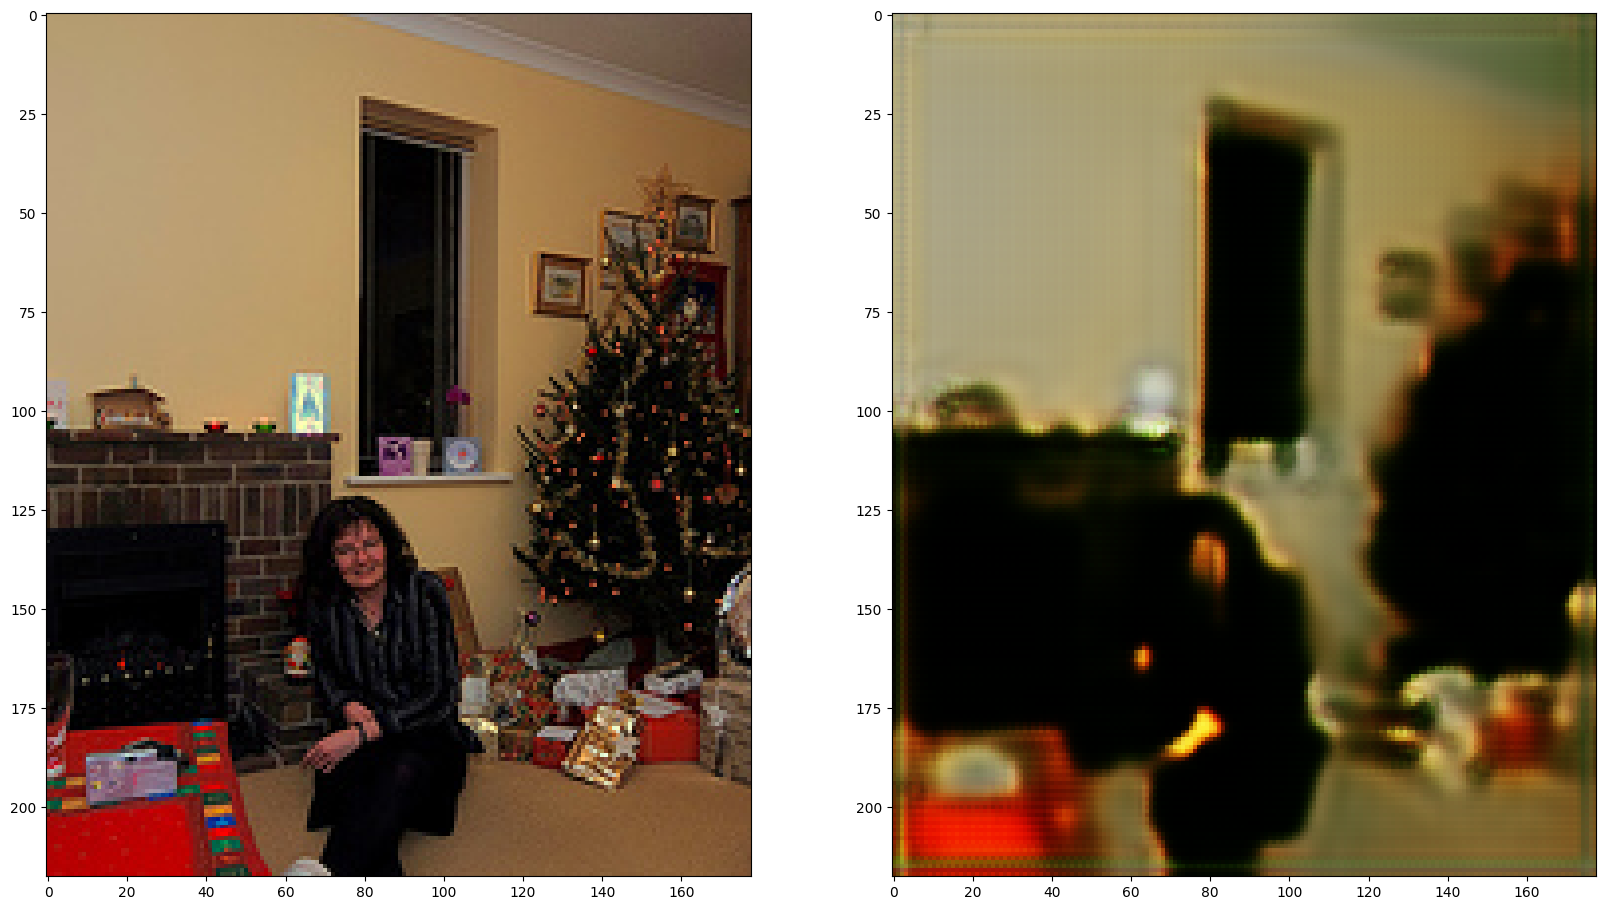

[2/7][50/1272]	Loss_D: 1.3695	Loss_G: 1.2164	Loss_E: 1.2153	D(x): 0.5390	D(G(z)): 0.5225 / 0.4960
[2/7][100/1272]	Loss_D: 1.3648	Loss_G: 1.3282	Loss_E: 1.3311	D(x): 0.5118	D(G(z)): 0.4986 / 0.4906
[2/7][150/1272]	Loss_D: 1.4071	Loss_G: 1.3084	Loss_E: 1.3092	D(x): 0.4618	D(G(z)): 0.4645 / 0.4721
[2/7][200/1272]	Loss_D: 1.4263	Loss_G: 1.4623	Loss_E: 1.4620	D(x): 0.4321	D(G(z)): 0.4431 / 0.4324
[2/7][250/1272]	Loss_D: 1.3505	Loss_G: 1.4618	Loss_E: 1.4614	D(x): 0.5087	D(G(z)): 0.4731 / 0.4620
[2/7][300/1272]	Loss_D: 1.3487	Loss_G: 1.3395	Loss_E: 1.3421	D(x): 0.4616	D(G(z)): 0.4229 / 0.4298
[2/7][350/1272]	Loss_D: 1.3674	Loss_G: 1.4265	Loss_E: 1.4261	D(x): 0.5400	D(G(z)): 0.5009 / 0.4508
[2/7][400/1272]	Loss_D: 1.3685	Loss_G: 1.4021	Loss_E: 1.4018	D(x): 0.6763	D(G(z)): 0.5917 / 0.4597
[2/7][450/1272]	Loss_D: 1.4288	Loss_G: 1.5066	Loss_E: 1.5056	D(x): 0.7310	D(G(z)): 0.6544 / 0.4354
[2/7][500/1272]	Loss_D: 1.3551	Loss_G: 1.2813	Loss_E: 1.2797	D(x): 0.4985	D(G(z)): 0.4712 / 0.4803


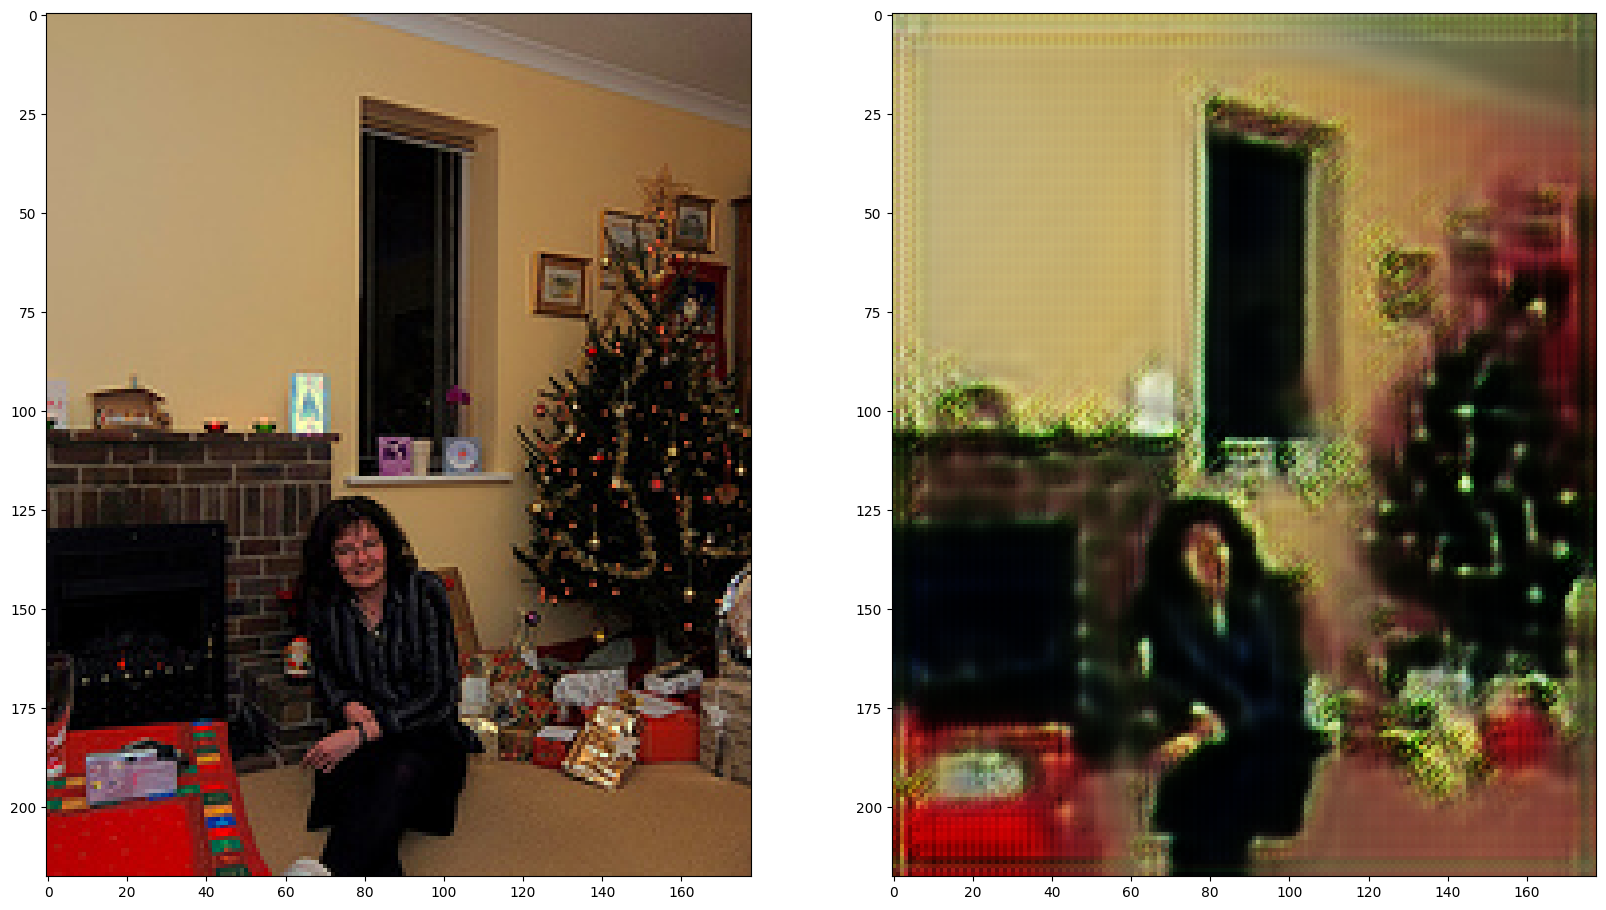

[2/7][550/1272]	Loss_D: 1.3363	Loss_G: 1.3832	Loss_E: 1.3842	D(x): 0.5215	D(G(z)): 0.4757 / 0.4539
[2/7][600/1272]	Loss_D: 1.5146	Loss_G: 1.3179	Loss_E: 1.3206	D(x): 0.5253	D(G(z)): 0.5669 / 0.5247
[2/7][650/1272]	Loss_D: 1.3482	Loss_G: 1.3203	Loss_E: 1.3189	D(x): 0.4752	D(G(z)): 0.4426 / 0.4475
[2/7][700/1272]	Loss_D: 1.3854	Loss_G: 1.3520	Loss_E: 1.3558	D(x): 0.4780	D(G(z)): 0.4678 / 0.4592
[2/7][750/1272]	Loss_D: 1.2252	Loss_G: 1.1039	Loss_E: 1.0969	D(x): 0.5761	D(G(z)): 0.4673 / 0.5672
[2/7][800/1272]	Loss_D: 1.2889	Loss_G: 1.2889	Loss_E: 1.2907	D(x): 0.5709	D(G(z)): 0.4940 / 0.4914
[2/7][850/1272]	Loss_D: 1.3015	Loss_G: 1.3967	Loss_E: 1.4006	D(x): 0.5401	D(G(z)): 0.4788 / 0.4690
[2/7][900/1272]	Loss_D: 1.3779	Loss_G: 1.2805	Loss_E: 1.2809	D(x): 0.4868	D(G(z)): 0.4759 / 0.4799
[2/7][950/1272]	Loss_D: 1.3548	Loss_G: 1.1705	Loss_E: 1.1679	D(x): 0.5049	D(G(z)): 0.4835 / 0.5097
[2/7][1000/1272]	Loss_D: 1.5093	Loss_G: 1.4537	Loss_E: 1.4503	D(x): 0.5097	D(G(z)): 0.5593 / 0.4827


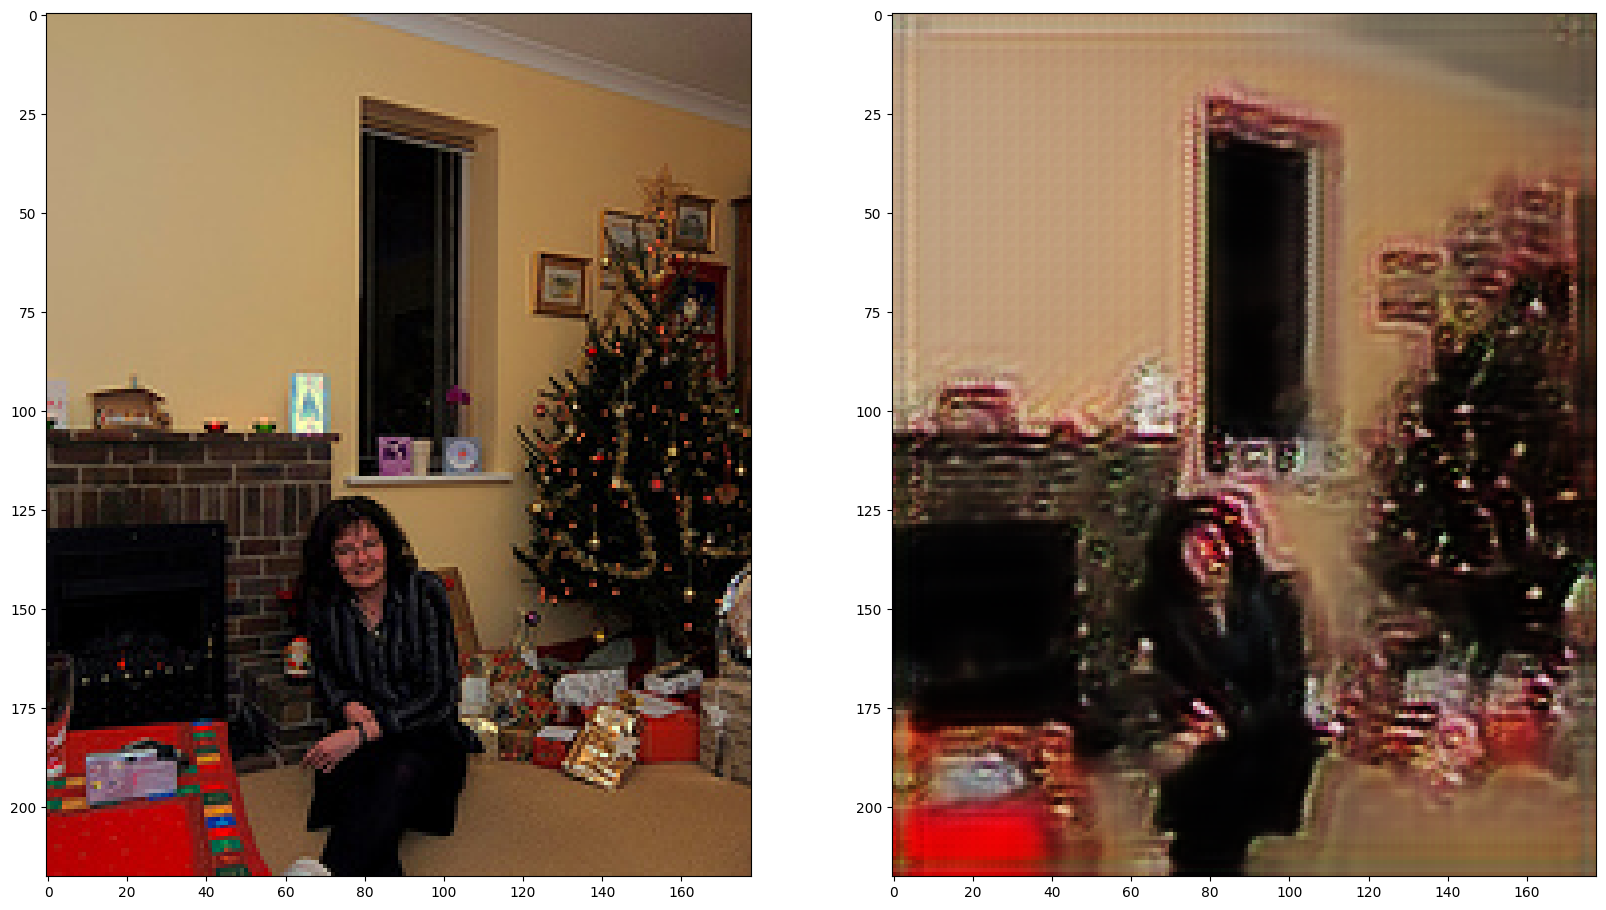

[2/7][1050/1272]	Loss_D: 1.3616	Loss_G: 1.2845	Loss_E: 1.2860	D(x): 0.4849	D(G(z)): 0.4616 / 0.4688
[2/7][1100/1272]	Loss_D: 1.3023	Loss_G: 1.1583	Loss_E: 1.1600	D(x): 0.5381	D(G(z)): 0.4746 / 0.5235
[2/7][1150/1272]	Loss_D: 1.3737	Loss_G: 1.3736	Loss_E: 1.3708	D(x): 0.4646	D(G(z)): 0.4499 / 0.4550
[2/7][1200/1272]	Loss_D: 1.3579	Loss_G: 1.3688	Loss_E: 1.3698	D(x): 0.4796	D(G(z)): 0.4585 / 0.4630
[2/7][1250/1272]	Loss_D: 1.3532	Loss_G: 1.4028	Loss_E: 1.4018	D(x): 0.5552	D(G(z)): 0.5226 / 0.4816
[3/7][0/1272]	Loss_D: 1.2779	Loss_G: 1.1982	Loss_E: 1.1991	D(x): 0.5593	D(G(z)): 0.4884 / 0.4805


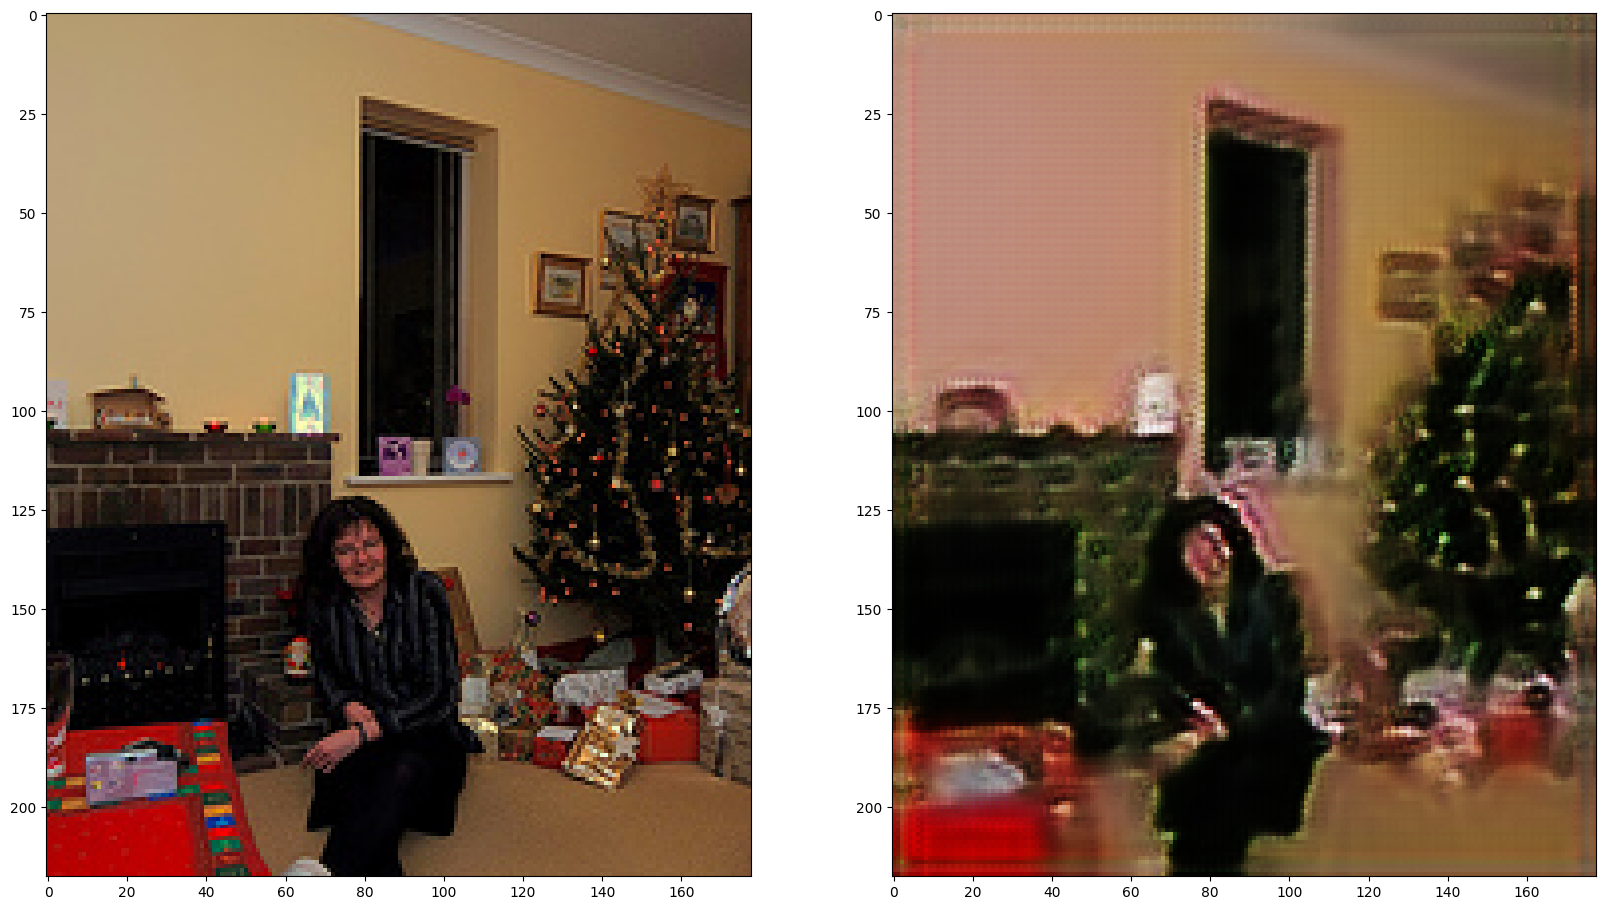

[3/7][50/1272]	Loss_D: 1.2936	Loss_G: 1.1482	Loss_E: 1.1474	D(x): 0.5754	D(G(z)): 0.5082 / 0.4957
[3/7][100/1272]	Loss_D: 1.3748	Loss_G: 1.2392	Loss_E: 1.2402	D(x): 0.5084	D(G(z)): 0.4931 / 0.4656
[3/7][150/1272]	Loss_D: 1.2939	Loss_G: 1.2087	Loss_E: 1.2118	D(x): 0.6277	D(G(z)): 0.5423 / 0.5049
[3/7][200/1272]	Loss_D: 1.3438	Loss_G: 1.3367	Loss_E: 1.3345	D(x): 0.4834	D(G(z)): 0.4505 / 0.4550
[3/7][250/1272]	Loss_D: 1.4753	Loss_G: 1.2668	Loss_E: 1.2656	D(x): 0.4782	D(G(z)): 0.5146 / 0.4895
[3/7][300/1272]	Loss_D: 1.3430	Loss_G: 1.1971	Loss_E: 1.1995	D(x): 0.6169	D(G(z)): 0.5521 / 0.5169
[3/7][350/1272]	Loss_D: 1.3350	Loss_G: 1.1590	Loss_E: 1.1589	D(x): 0.5633	D(G(z)): 0.5194 / 0.5110
[3/7][400/1272]	Loss_D: 1.3813	Loss_G: 1.3421	Loss_E: 1.3414	D(x): 0.4522	D(G(z)): 0.4432 / 0.4450
[3/7][450/1272]	Loss_D: 1.2906	Loss_G: 1.1884	Loss_E: 1.1910	D(x): 0.5393	D(G(z)): 0.4776 / 0.4830
[3/7][500/1272]	Loss_D: 1.3543	Loss_G: 1.2659	Loss_E: 1.2635	D(x): 0.4951	D(G(z)): 0.4695 / 0.4636


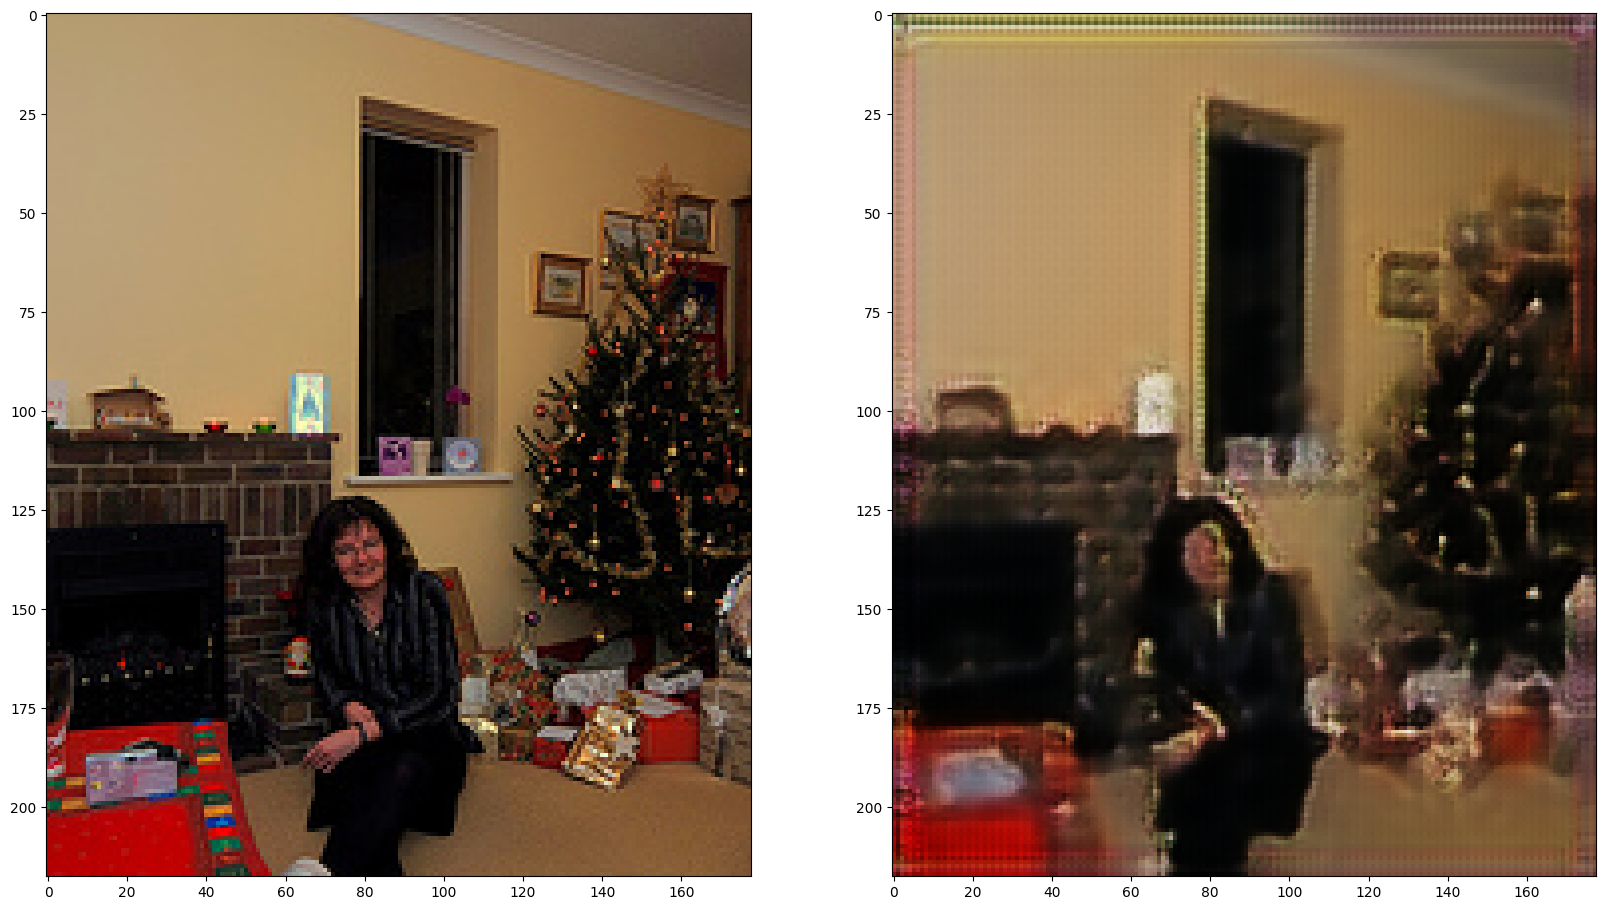

[3/7][550/1272]	Loss_D: 1.3303	Loss_G: 1.2627	Loss_E: 1.2626	D(x): 0.4946	D(G(z)): 0.4543 / 0.4604
[3/7][600/1272]	Loss_D: 1.3324	Loss_G: 1.1682	Loss_E: 1.1681	D(x): 0.4991	D(G(z)): 0.4639 / 0.4846
[3/7][650/1272]	Loss_D: 1.3888	Loss_G: 1.2048	Loss_E: 1.2046	D(x): 0.4573	D(G(z)): 0.4497 / 0.4536
[3/7][700/1272]	Loss_D: 1.3324	Loss_G: 1.2403	Loss_E: 1.2374	D(x): 0.5186	D(G(z)): 0.4819 / 0.5050
[3/7][750/1272]	Loss_D: 1.4292	Loss_G: 1.3341	Loss_E: 1.3331	D(x): 0.5058	D(G(z)): 0.5187 / 0.4843
[3/7][800/1272]	Loss_D: 1.2880	Loss_G: 1.1748	Loss_E: 1.1699	D(x): 0.5478	D(G(z)): 0.4769 / 0.5066
[3/7][850/1272]	Loss_D: 1.3648	Loss_G: 1.1907	Loss_E: 1.1935	D(x): 0.4898	D(G(z)): 0.4707 / 0.4816
[3/7][900/1272]	Loss_D: 1.3870	Loss_G: 1.2620	Loss_E: 1.2618	D(x): 0.4625	D(G(z)): 0.4606 / 0.4567
[3/7][950/1272]	Loss_D: 1.3444	Loss_G: 1.2195	Loss_E: 1.2166	D(x): 0.6311	D(G(z)): 0.5584 / 0.4834
[3/7][1000/1272]	Loss_D: 1.3472	Loss_G: 1.2603	Loss_E: 1.2580	D(x): 0.5014	D(G(z)): 0.4745 / 0.4737


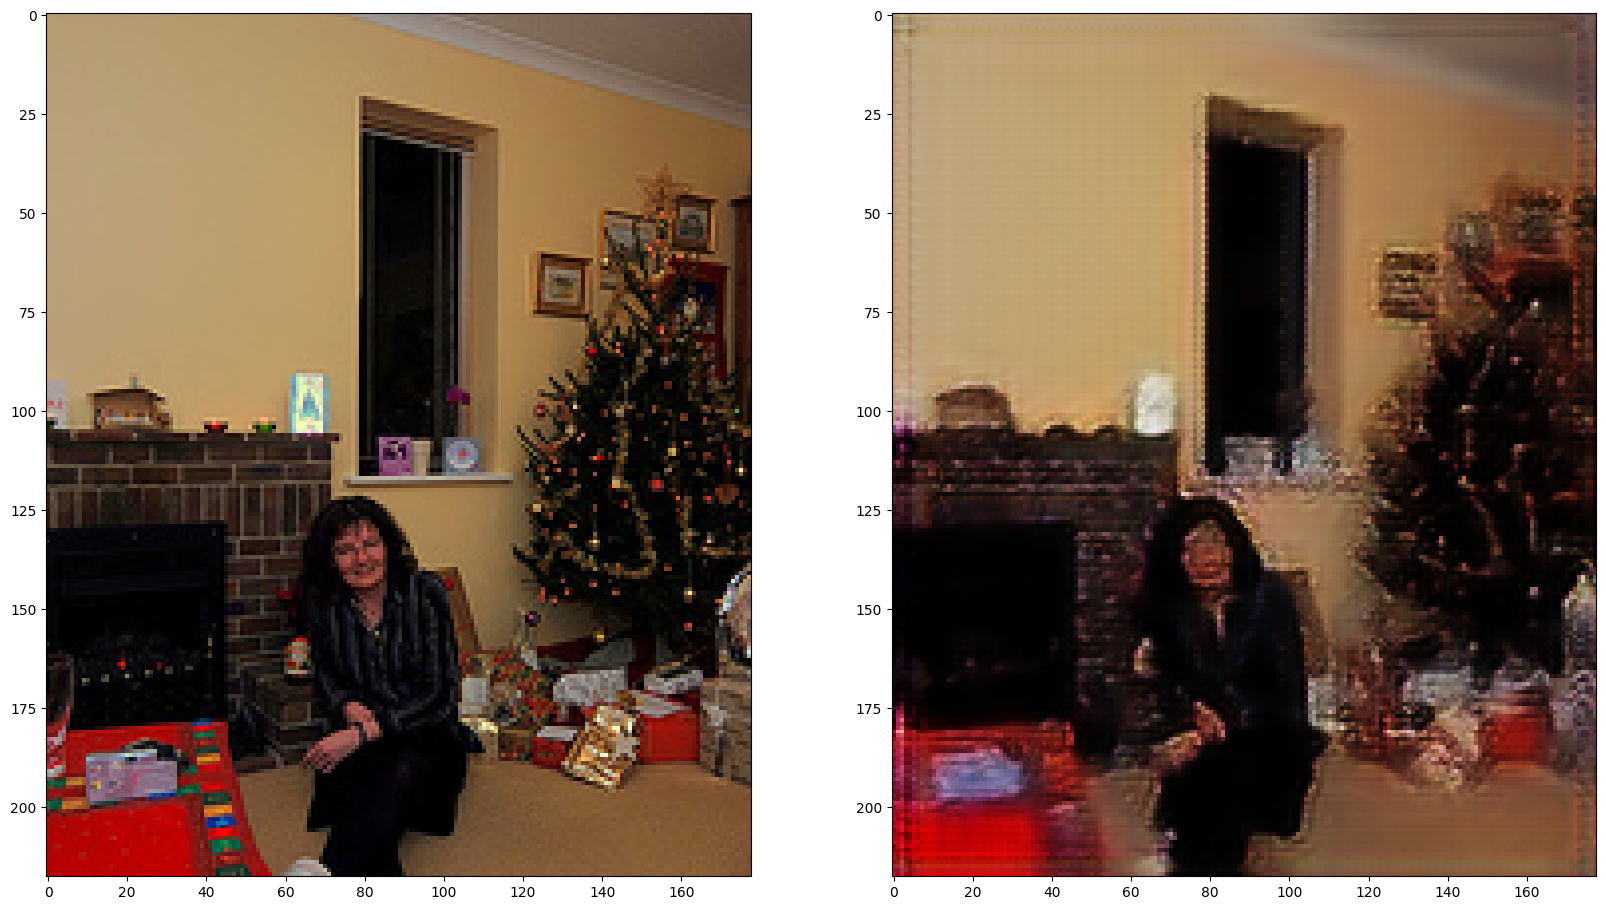

[3/7][1050/1272]	Loss_D: 1.3388	Loss_G: 1.2020	Loss_E: 1.2144	D(x): 0.5958	D(G(z)): 0.5432 / 0.5211
[3/7][1100/1272]	Loss_D: 1.3381	Loss_G: 1.2843	Loss_E: 1.2825	D(x): 0.4843	D(G(z)): 0.4481 / 0.4714
[3/7][1150/1272]	Loss_D: 1.3467	Loss_G: 1.2041	Loss_E: 1.2070	D(x): 0.4854	D(G(z)): 0.4573 / 0.4710
[3/7][1200/1272]	Loss_D: 1.4716	Loss_G: 1.3059	Loss_E: 1.3096	D(x): 0.5082	D(G(z)): 0.5352 / 0.4540
[3/7][1250/1272]	Loss_D: 1.3393	Loss_G: 1.1931	Loss_E: 1.1924	D(x): 0.5654	D(G(z)): 0.5251 / 0.4845
[4/7][0/1272]	Loss_D: 1.3609	Loss_G: 1.2918	Loss_E: 1.2932	D(x): 0.4634	D(G(z)): 0.4441 / 0.4480


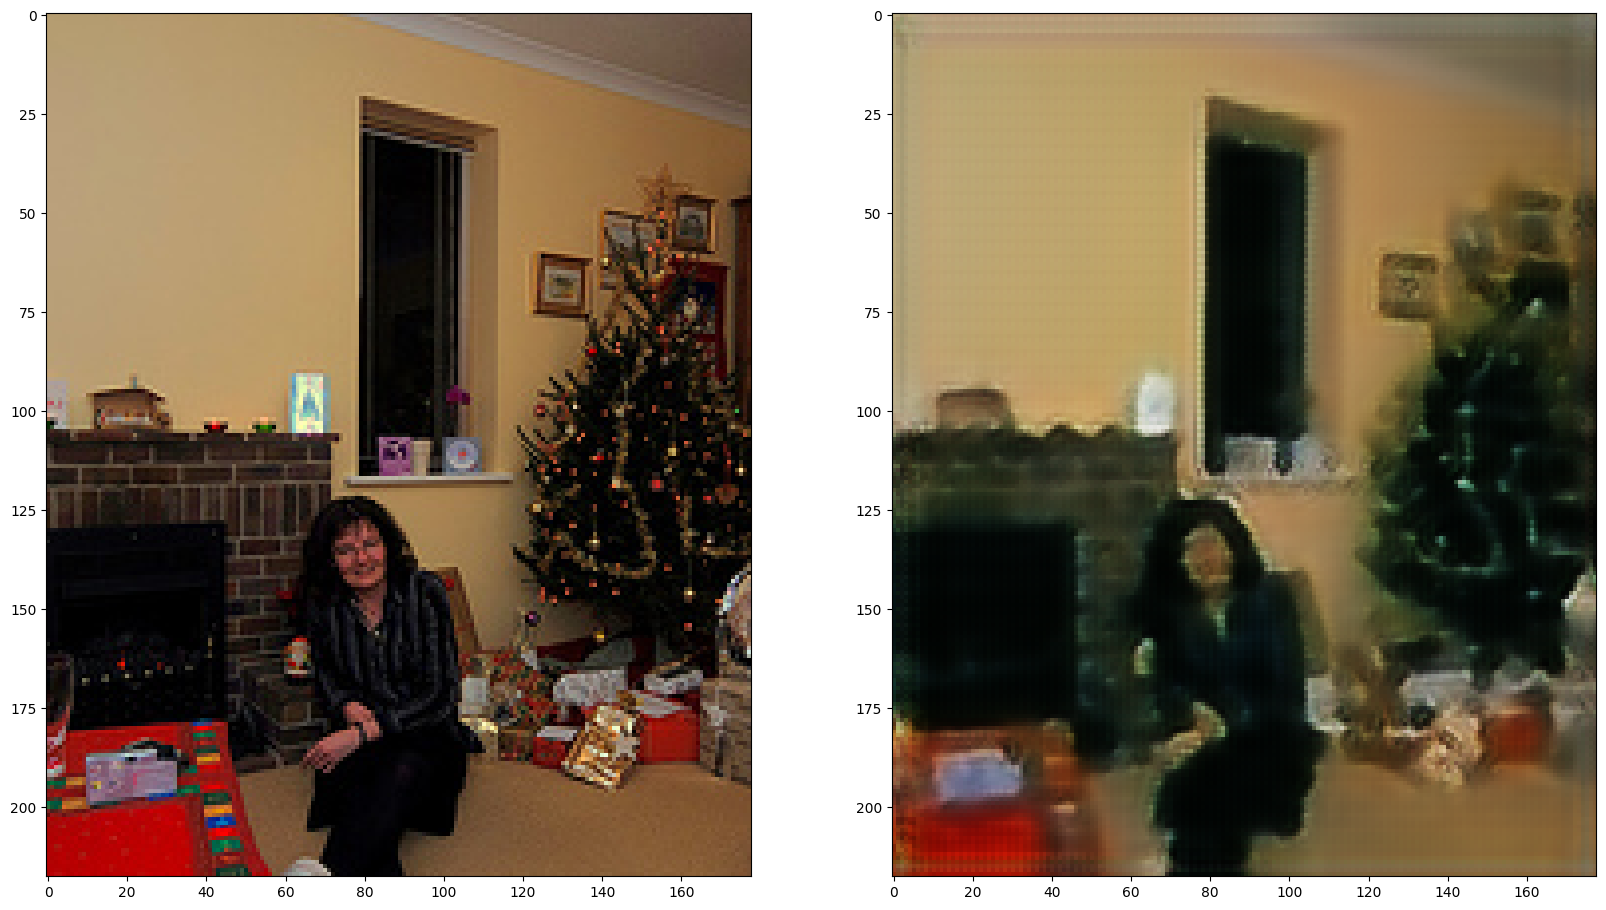

[4/7][50/1272]	Loss_D: 1.4431	Loss_G: 1.1795	Loss_E: 1.1765	D(x): 0.5953	D(G(z)): 0.5878 / 0.5080
[4/7][100/1272]	Loss_D: 1.3851	Loss_G: 1.2996	Loss_E: 1.2956	D(x): 0.4489	D(G(z)): 0.4399 / 0.4448
[4/7][150/1272]	Loss_D: 1.3773	Loss_G: 1.1472	Loss_E: 1.1478	D(x): 0.4959	D(G(z)): 0.4845 / 0.4981
[4/7][200/1272]	Loss_D: 1.3574	Loss_G: 1.2012	Loss_E: 1.2043	D(x): 0.4738	D(G(z)): 0.4523 / 0.4591
[4/7][250/1272]	Loss_D: 1.4230	Loss_G: 1.1787	Loss_E: 1.1782	D(x): 0.5273	D(G(z)): 0.5264 / 0.4962
[4/7][300/1272]	Loss_D: 1.3301	Loss_G: 1.1322	Loss_E: 1.1297	D(x): 0.5634	D(G(z)): 0.5183 / 0.5172
[4/7][350/1272]	Loss_D: 1.3956	Loss_G: 1.2458	Loss_E: 1.2489	D(x): 0.4452	D(G(z)): 0.4413 / 0.4446
[4/7][400/1272]	Loss_D: 1.3832	Loss_G: 1.3106	Loss_E: 1.3085	D(x): 0.5276	D(G(z)): 0.5113 / 0.4870
[4/7][450/1272]	Loss_D: 1.3081	Loss_G: 1.2387	Loss_E: 1.2378	D(x): 0.4982	D(G(z)): 0.4433 / 0.4691
[4/7][500/1272]	Loss_D: 1.3787	Loss_G: 1.2529	Loss_E: 1.2566	D(x): 0.4728	D(G(z)): 0.4625 / 0.4642


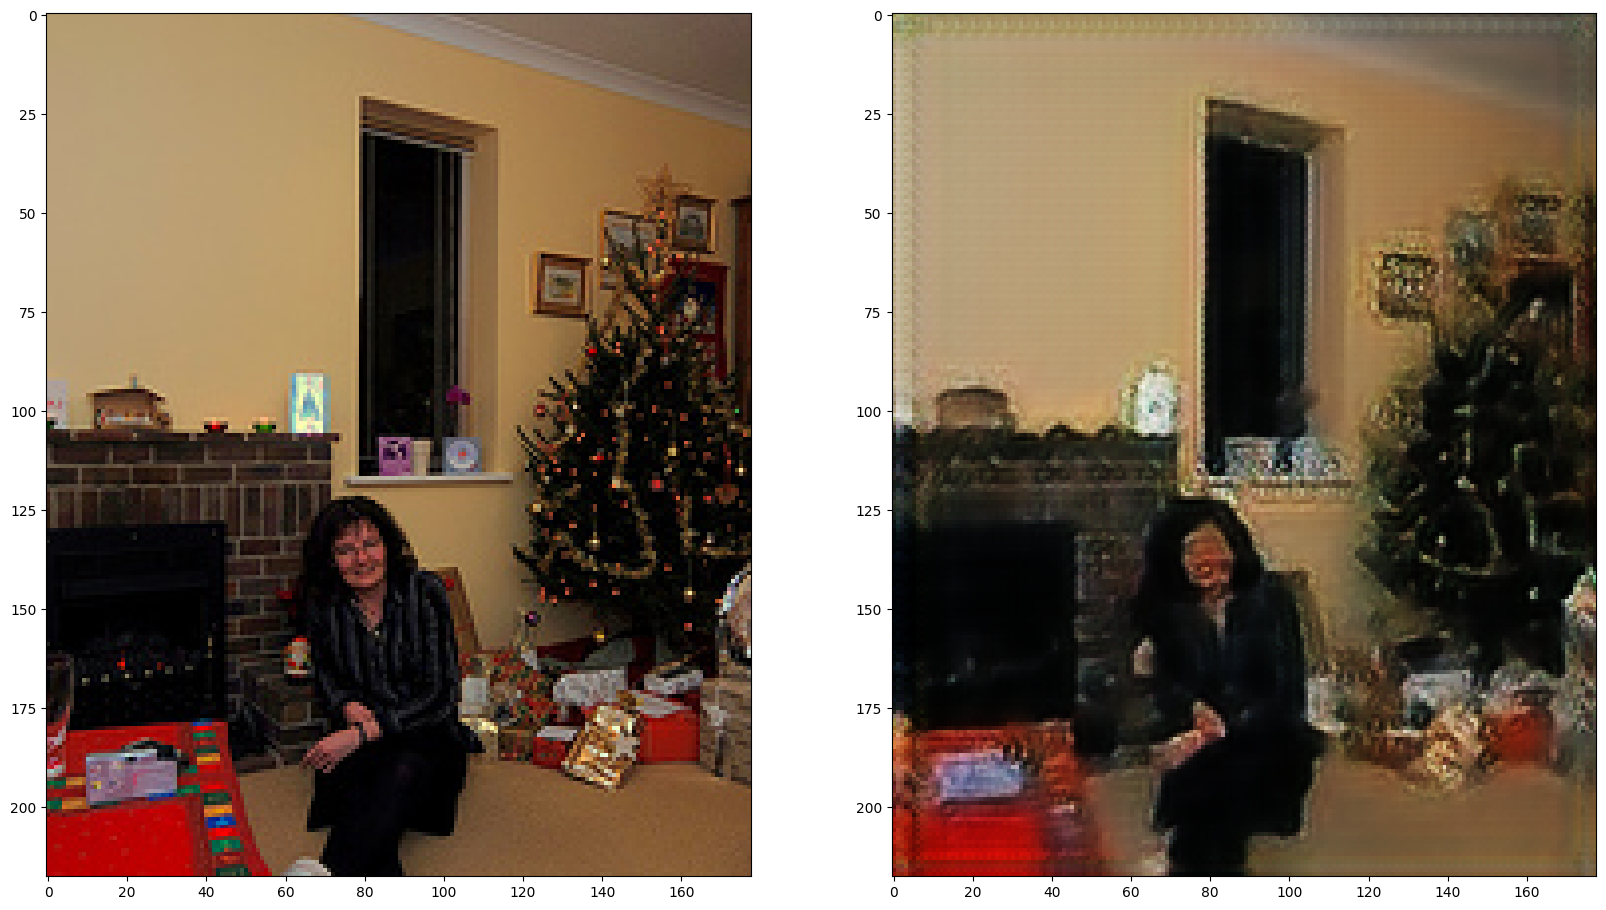

[4/7][550/1272]	Loss_D: 1.3429	Loss_G: 1.2479	Loss_E: 1.2477	D(x): 0.5032	D(G(z)): 0.4718 / 0.4836
[4/7][600/1272]	Loss_D: 1.3282	Loss_G: 1.2654	Loss_E: 1.2679	D(x): 0.4920	D(G(z)): 0.4505 / 0.4743
[4/7][650/1272]	Loss_D: 1.3611	Loss_G: 1.3404	Loss_E: 1.3325	D(x): 0.5153	D(G(z)): 0.4925 / 0.4583
[4/7][700/1272]	Loss_D: 1.3827	Loss_G: 1.2596	Loss_E: 1.2615	D(x): 0.4343	D(G(z)): 0.4179 / 0.4256
[4/7][750/1272]	Loss_D: 1.4094	Loss_G: 1.2975	Loss_E: 1.2943	D(x): 0.4764	D(G(z)): 0.4809 / 0.4549
[4/7][800/1272]	Loss_D: 1.3716	Loss_G: 1.2027	Loss_E: 1.2001	D(x): 0.4735	D(G(z)): 0.4594 / 0.4588
[4/7][850/1272]	Loss_D: 1.3985	Loss_G: 1.2088	Loss_E: 1.2082	D(x): 0.4826	D(G(z)): 0.4847 / 0.4749
[4/7][900/1272]	Loss_D: 1.3277	Loss_G: 1.2315	Loss_E: 1.2342	D(x): 0.4938	D(G(z)): 0.4544 / 0.4717
[4/7][950/1272]	Loss_D: 1.3275	Loss_G: 1.0767	Loss_E: 1.0867	D(x): 0.5710	D(G(z)): 0.5247 / 0.5359
[4/7][1000/1272]	Loss_D: 1.3712	Loss_G: 1.3752	Loss_E: 1.3818	D(x): 0.4911	D(G(z)): 0.4741 / 0.4673


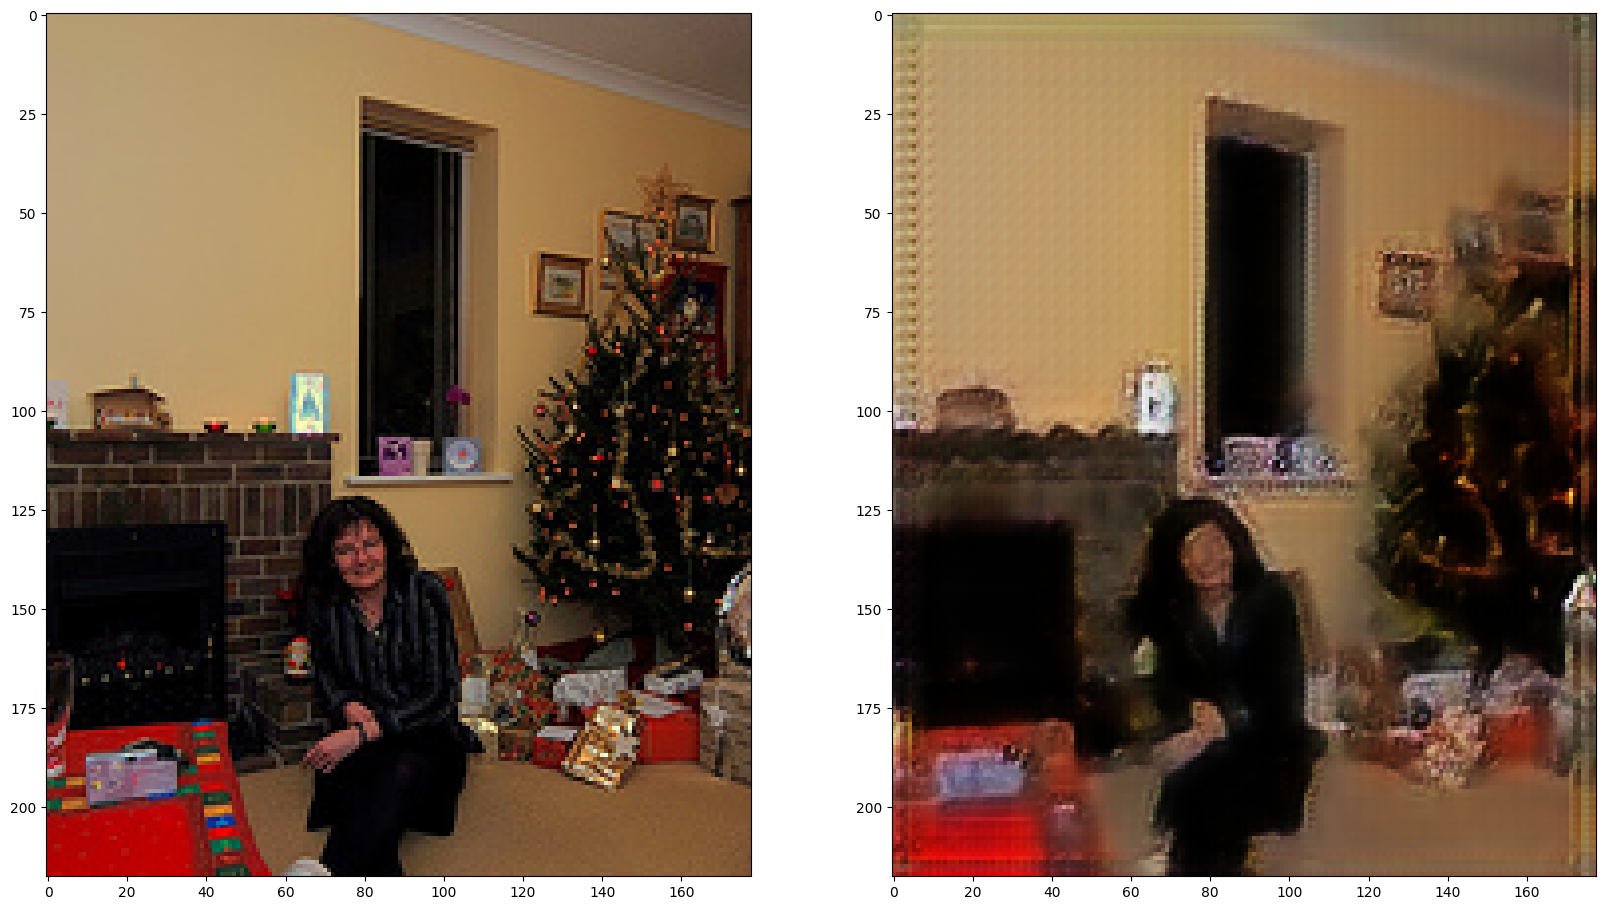

[4/7][1050/1272]	Loss_D: 1.6250	Loss_G: 1.2781	Loss_E: 1.2740	D(x): 0.5424	D(G(z)): 0.6205 / 0.4757
[4/7][1100/1272]	Loss_D: 1.3913	Loss_G: 1.2449	Loss_E: 1.2508	D(x): 0.5186	D(G(z)): 0.5098 / 0.4928
[4/7][1150/1272]	Loss_D: 1.3541	Loss_G: 1.1814	Loss_E: 1.1820	D(x): 0.5075	D(G(z)): 0.4846 / 0.4919
[4/7][1200/1272]	Loss_D: 1.3468	Loss_G: 1.0855	Loss_E: 1.0821	D(x): 0.5444	D(G(z)): 0.5153 / 0.5097
[4/7][1250/1272]	Loss_D: 1.4683	Loss_G: 1.1670	Loss_E: 1.1680	D(x): 0.5445	D(G(z)): 0.5697 / 0.5180
[5/7][0/1272]	Loss_D: 1.3249	Loss_G: 1.2024	Loss_E: 1.2013	D(x): 0.5541	D(G(z)): 0.5089 / 0.4986


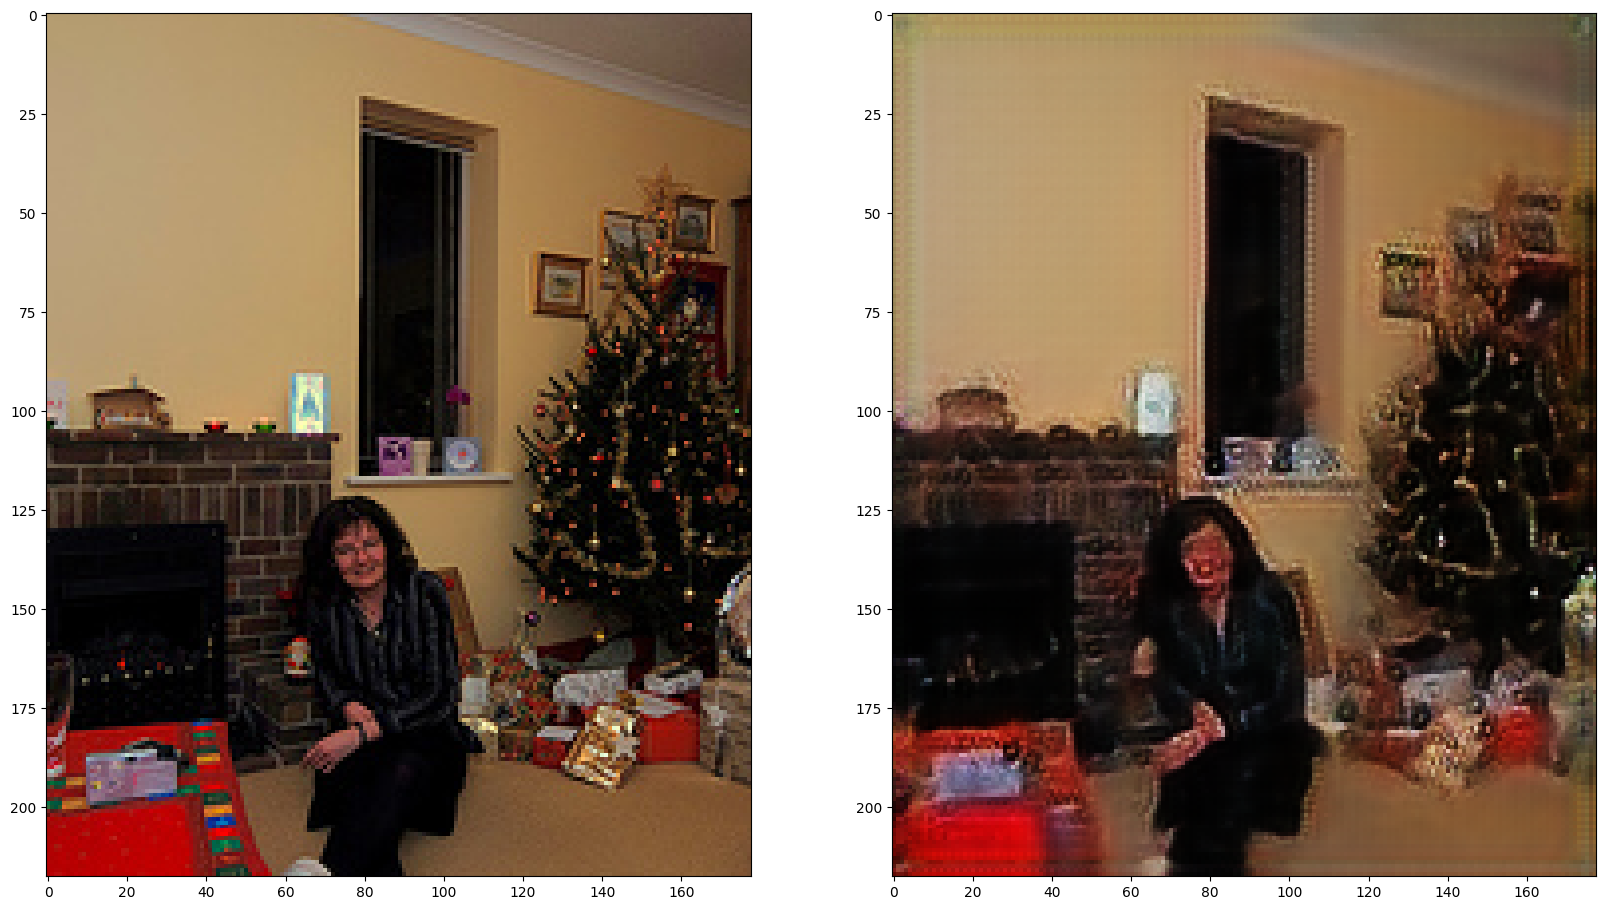

[5/7][50/1272]	Loss_D: 1.5109	Loss_G: 1.2781	Loss_E: 1.2786	D(x): 0.4808	D(G(z)): 0.5410 / 0.4852
[5/7][100/1272]	Loss_D: 1.3407	Loss_G: 1.0984	Loss_E: 1.1015	D(x): 0.5214	D(G(z)): 0.4840 / 0.5045
[5/7][150/1272]	Loss_D: 1.3613	Loss_G: 1.0750	Loss_E: 1.0760	D(x): 0.5595	D(G(z)): 0.5303 / 0.5148
[5/7][200/1272]	Loss_D: 1.4586	Loss_G: 1.3302	Loss_E: 1.3264	D(x): 0.4575	D(G(z)): 0.4854 / 0.4245
[5/7][250/1272]	Loss_D: 1.3819	Loss_G: 1.1781	Loss_E: 1.1776	D(x): 0.4594	D(G(z)): 0.4487 / 0.4524
[5/7][300/1272]	Loss_D: 1.3574	Loss_G: 1.1639	Loss_E: 1.1583	D(x): 0.5362	D(G(z)): 0.5154 / 0.5038
[5/7][350/1272]	Loss_D: 1.3613	Loss_G: 1.1995	Loss_E: 1.1976	D(x): 0.5267	D(G(z)): 0.4954 / 0.4821
[5/7][400/1272]	Loss_D: 1.3805	Loss_G: 1.2345	Loss_E: 1.2366	D(x): 0.4659	D(G(z)): 0.4542 / 0.4526
[5/7][450/1272]	Loss_D: 1.3343	Loss_G: 1.1579	Loss_E: 1.1503	D(x): 0.5292	D(G(z)): 0.4921 / 0.4882
[5/7][500/1272]	Loss_D: 1.3576	Loss_G: 1.2371	Loss_E: 1.2383	D(x): 0.4927	D(G(z)): 0.4645 / 0.4702


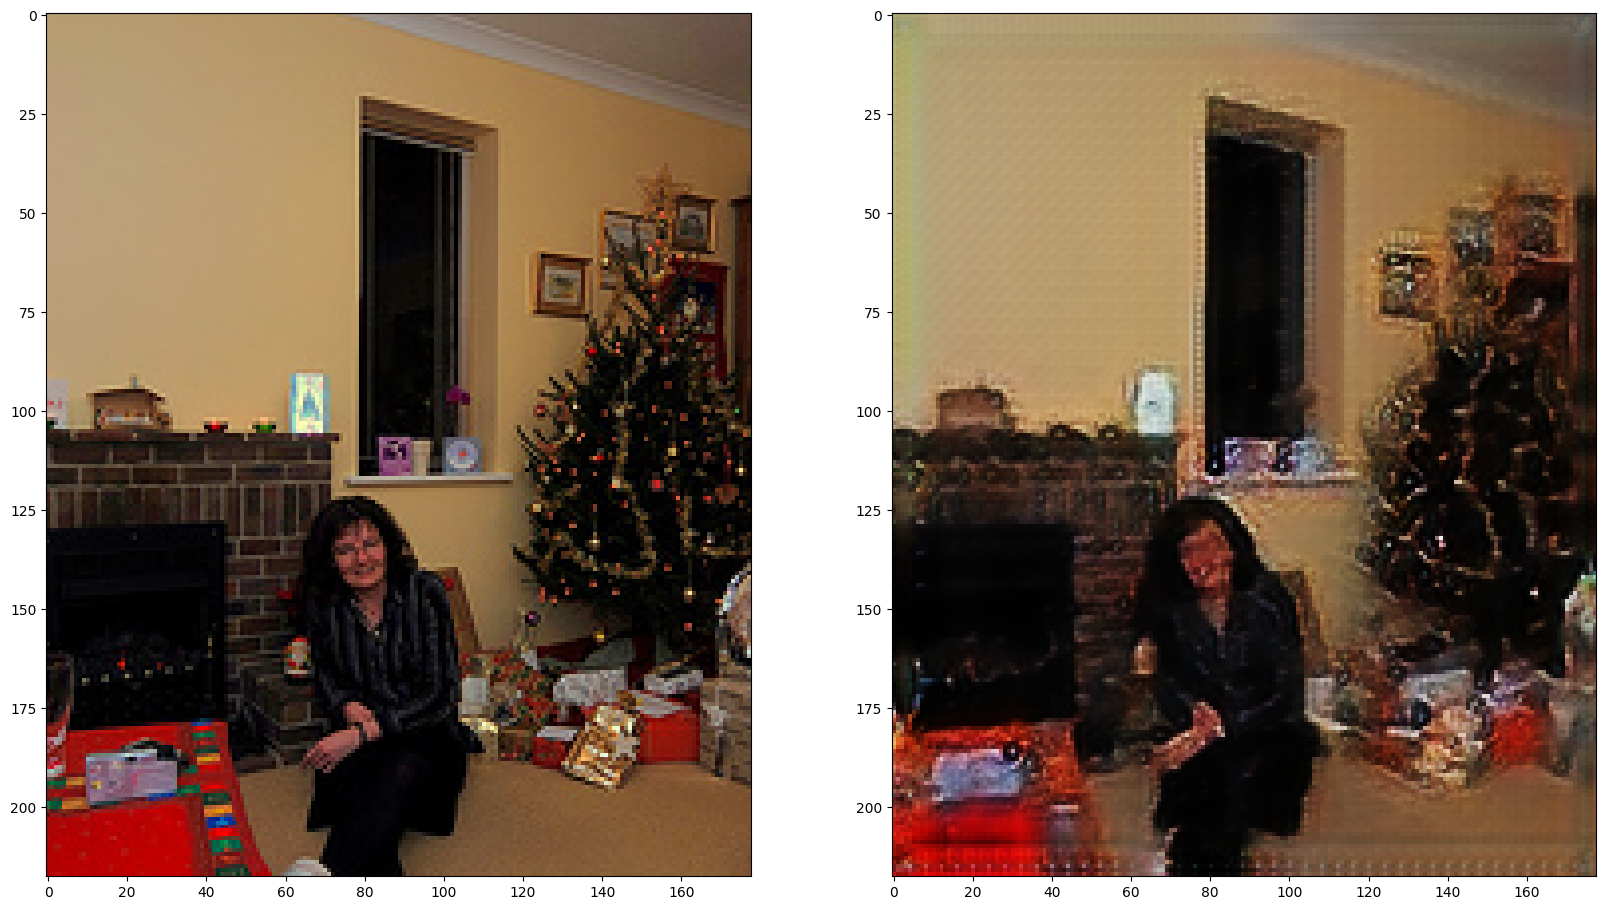

[5/7][550/1272]	Loss_D: 1.3875	Loss_G: 1.2530	Loss_E: 1.2526	D(x): 0.5230	D(G(z)): 0.5130 / 0.4935
[5/7][600/1272]	Loss_D: 1.3596	Loss_G: 1.2284	Loss_E: 1.2198	D(x): 0.5011	D(G(z)): 0.4795 / 0.4724
[5/7][650/1272]	Loss_D: 1.3590	Loss_G: 1.1752	Loss_E: 1.1702	D(x): 0.4737	D(G(z)): 0.4484 / 0.4614
[5/7][700/1272]	Loss_D: 1.3849	Loss_G: 1.0591	Loss_E: 1.0628	D(x): 0.5404	D(G(z)): 0.5272 / 0.5006
[5/7][750/1272]	Loss_D: 1.3512	Loss_G: 1.1639	Loss_E: 1.1525	D(x): 0.5167	D(G(z)): 0.4866 / 0.5059
[5/7][800/1272]	Loss_D: 1.3570	Loss_G: 1.1834	Loss_E: 1.1864	D(x): 0.4872	D(G(z)): 0.4656 / 0.4772
[5/7][850/1272]	Loss_D: 1.3326	Loss_G: 1.1883	Loss_E: 1.1869	D(x): 0.4887	D(G(z)): 0.4483 / 0.4641
[5/7][900/1272]	Loss_D: 1.3994	Loss_G: 1.2425	Loss_E: 1.2360	D(x): 0.4516	D(G(z)): 0.4497 / 0.4421
[5/7][950/1272]	Loss_D: 1.3691	Loss_G: 1.2425	Loss_E: 1.2386	D(x): 0.5424	D(G(z)): 0.5190 / 0.4880
[5/7][1000/1272]	Loss_D: 1.3077	Loss_G: 1.1836	Loss_E: 1.1870	D(x): 0.5344	D(G(z)): 0.4771 / 0.4807


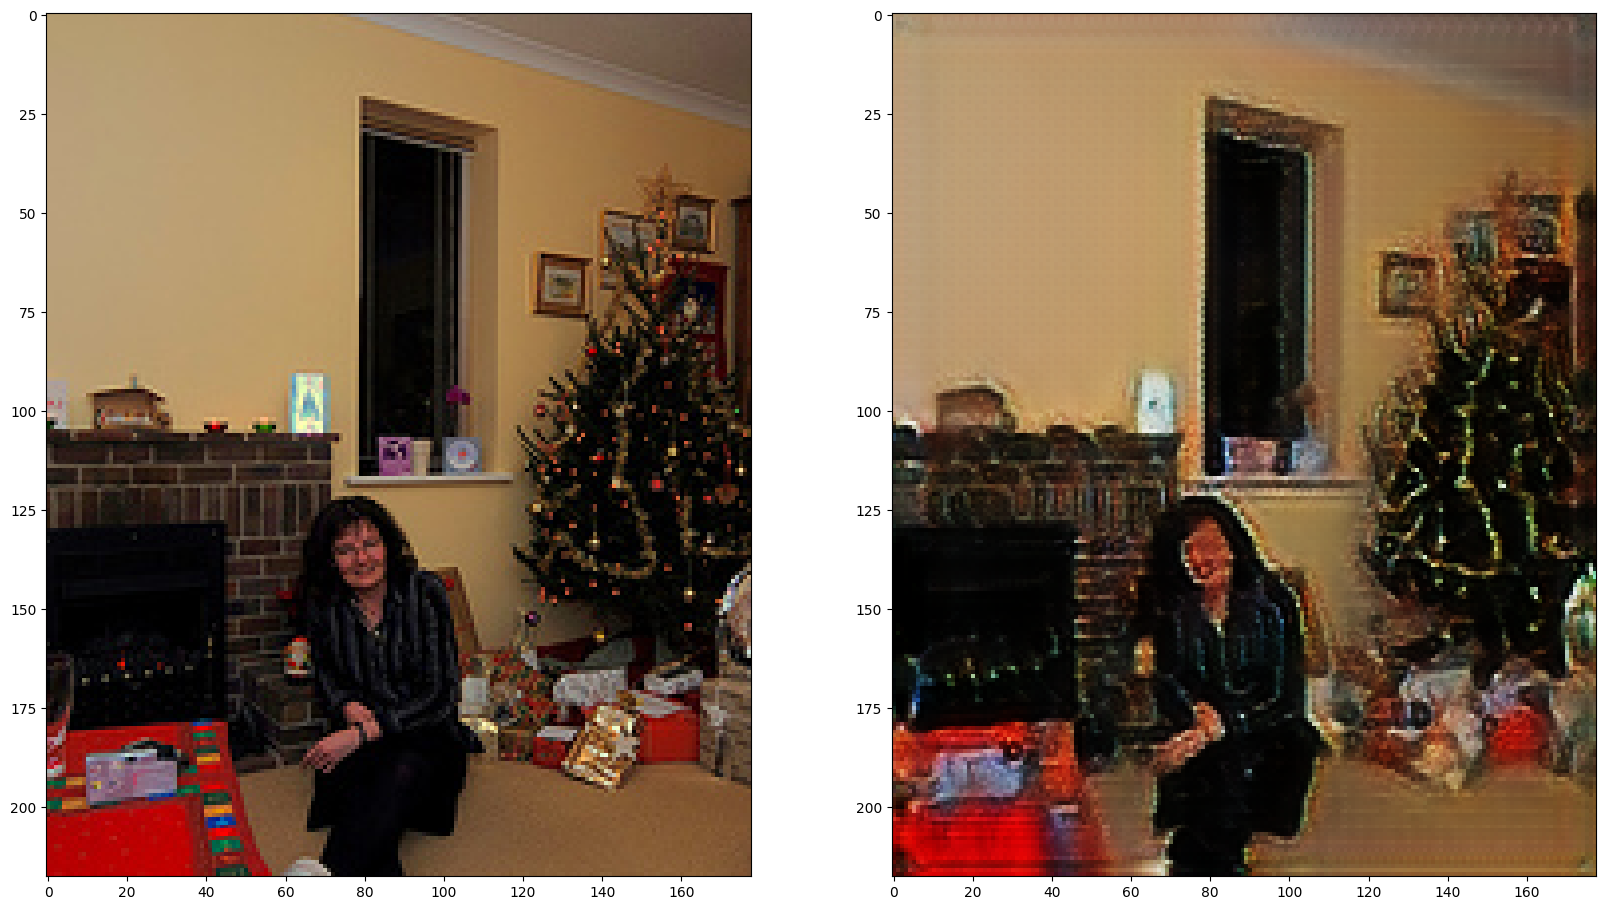

[5/7][1050/1272]	Loss_D: 1.3563	Loss_G: 1.2341	Loss_E: 1.2440	D(x): 0.5002	D(G(z)): 0.4749 / 0.4646
[5/7][1100/1272]	Loss_D: 1.3682	Loss_G: 1.0917	Loss_E: 1.0830	D(x): 0.5373	D(G(z)): 0.5178 / 0.5257
[5/7][1150/1272]	Loss_D: 1.3798	Loss_G: 1.2277	Loss_E: 1.2251	D(x): 0.4835	D(G(z)): 0.4746 / 0.4650
[5/7][1200/1272]	Loss_D: 1.3883	Loss_G: 1.2161	Loss_E: 1.2308	D(x): 0.5593	D(G(z)): 0.5306 / 0.4844
[5/7][1250/1272]	Loss_D: 1.5151	Loss_G: 1.1996	Loss_E: 1.2175	D(x): 0.5978	D(G(z)): 0.6048 / 0.5029
[6/7][0/1272]	Loss_D: 1.3983	Loss_G: 1.2602	Loss_E: 1.2565	D(x): 0.5344	D(G(z)): 0.5268 / 0.4629


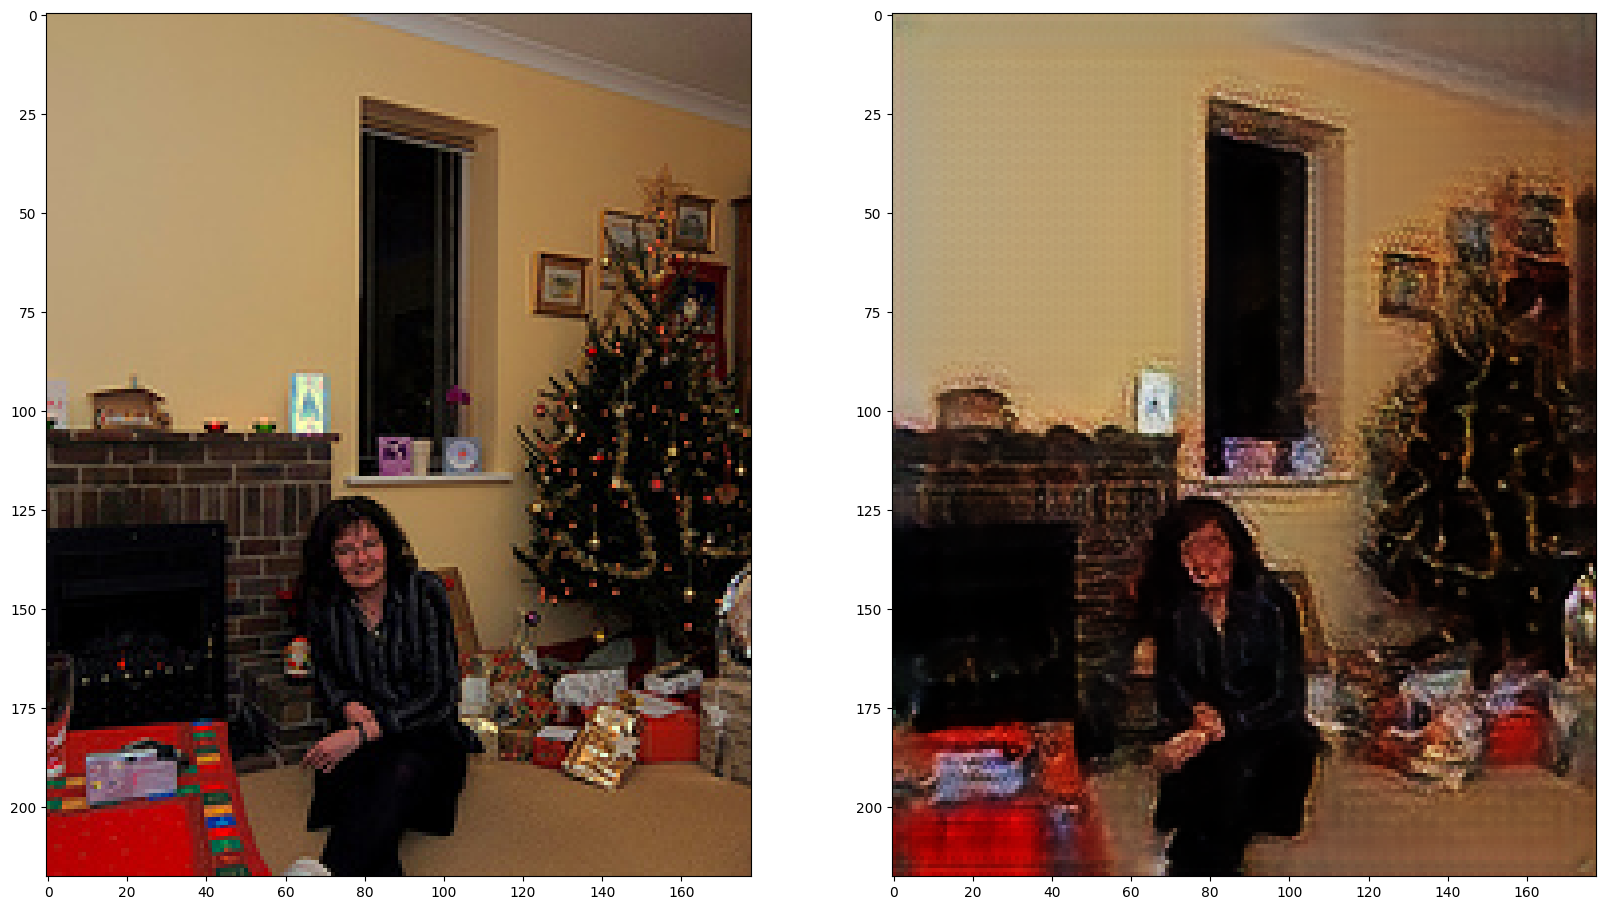

[6/7][50/1272]	Loss_D: 1.4749	Loss_G: 1.2604	Loss_E: 1.2609	D(x): 0.5139	D(G(z)): 0.5448 / 0.4604
[6/7][100/1272]	Loss_D: 1.3507	Loss_G: 1.0864	Loss_E: 1.0847	D(x): 0.5173	D(G(z)): 0.4920 / 0.4816
[6/7][150/1272]	Loss_D: 1.3513	Loss_G: 1.1011	Loss_E: 1.0968	D(x): 0.5081	D(G(z)): 0.4823 / 0.4852
[6/7][200/1272]	Loss_D: 1.3732	Loss_G: 1.2371	Loss_E: 1.2320	D(x): 0.4875	D(G(z)): 0.4739 / 0.4617
[6/7][250/1272]	Loss_D: 1.3174	Loss_G: 1.2222	Loss_E: 1.2205	D(x): 0.5741	D(G(z)): 0.5200 / 0.4795
[6/7][300/1272]	Loss_D: 1.3706	Loss_G: 1.1376	Loss_E: 1.1375	D(x): 0.4718	D(G(z)): 0.4567 / 0.4764
[6/7][350/1272]	Loss_D: 1.3880	Loss_G: 1.2116	Loss_E: 1.2123	D(x): 0.4400	D(G(z)): 0.4289 / 0.4382
[6/7][400/1272]	Loss_D: 1.3735	Loss_G: 1.1507	Loss_E: 1.1531	D(x): 0.4523	D(G(z)): 0.4355 / 0.4480
[6/7][450/1272]	Loss_D: 1.3666	Loss_G: 1.1283	Loss_E: 1.1394	D(x): 0.5011	D(G(z)): 0.4827 / 0.4954
[6/7][500/1272]	Loss_D: 1.3624	Loss_G: 1.1150	Loss_E: 1.1281	D(x): 0.5181	D(G(z)): 0.5006 / 0.5066


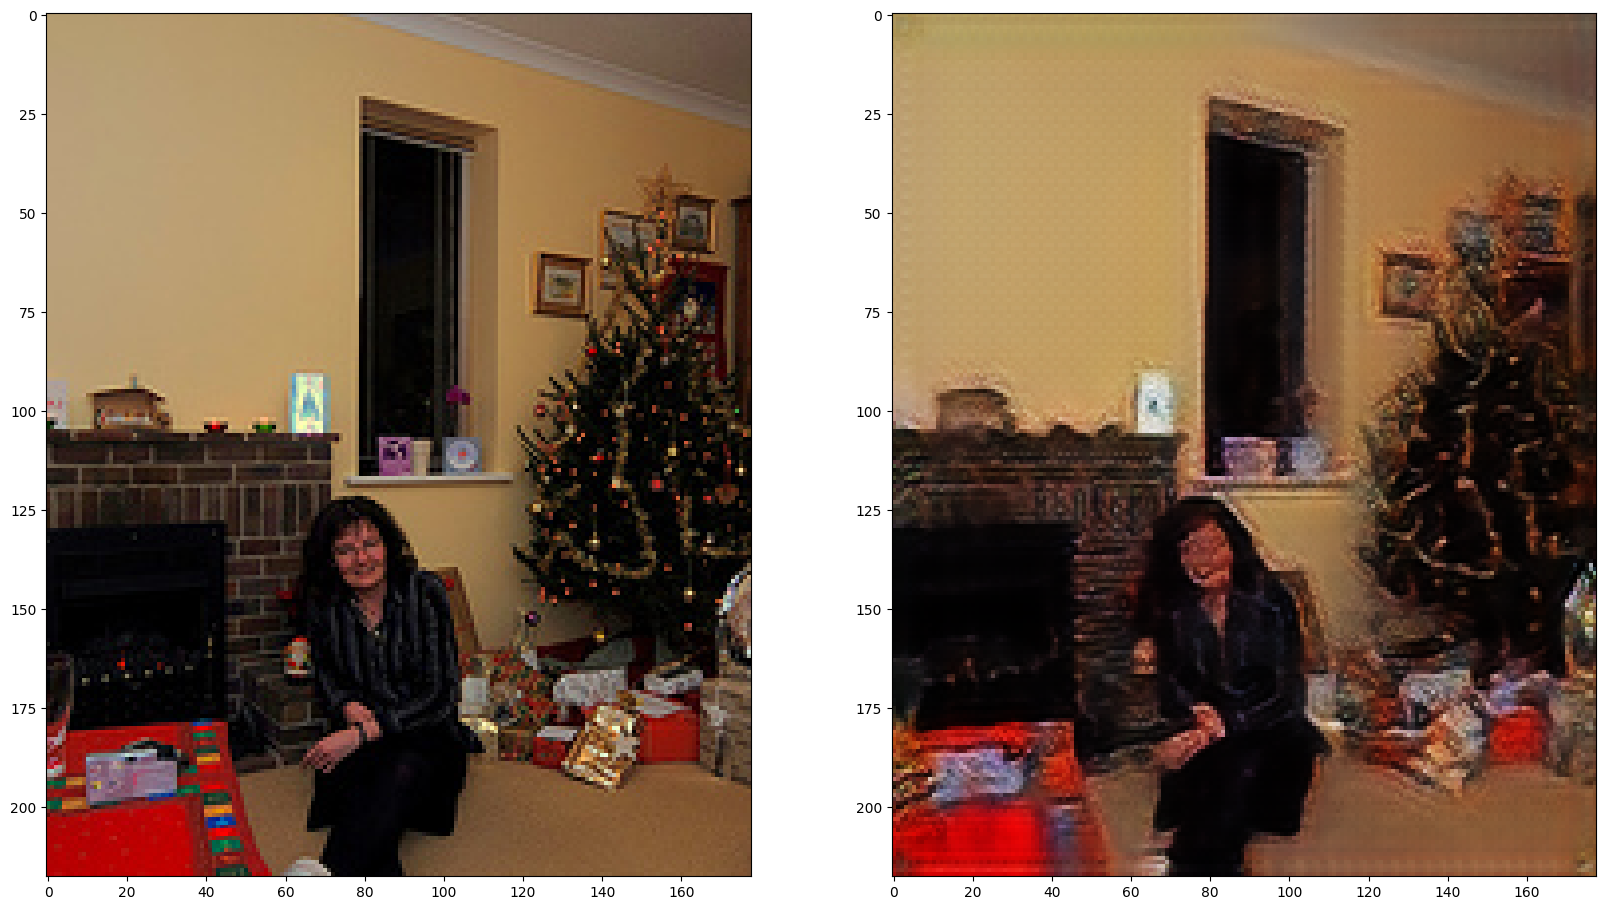

[6/7][550/1272]	Loss_D: 1.3797	Loss_G: 1.1512	Loss_E: 1.1583	D(x): 0.5358	D(G(z)): 0.5221 / 0.5085
[6/7][600/1272]	Loss_D: 1.4185	Loss_G: 1.2242	Loss_E: 1.2146	D(x): 0.4473	D(G(z)): 0.4441 / 0.4373
[6/7][650/1272]	Loss_D: 1.3417	Loss_G: 1.1122	Loss_E: 1.1169	D(x): 0.5963	D(G(z)): 0.5502 / 0.4674
[6/7][700/1272]	Loss_D: 1.3556	Loss_G: 1.1587	Loss_E: 1.1629	D(x): 0.5220	D(G(z)): 0.4950 / 0.4611
[6/7][750/1272]	Loss_D: 1.3802	Loss_G: 1.1516	Loss_E: 1.1563	D(x): 0.4707	D(G(z)): 0.4619 / 0.4671
[6/7][800/1272]	Loss_D: 1.3640	Loss_G: 1.2794	Loss_E: 1.2824	D(x): 0.4755	D(G(z)): 0.4529 / 0.4456
[6/7][850/1272]	Loss_D: 1.3311	Loss_G: 1.1967	Loss_E: 1.1928	D(x): 0.5068	D(G(z)): 0.4658 / 0.4664
[6/7][900/1272]	Loss_D: 1.3647	Loss_G: 1.2011	Loss_E: 1.2044	D(x): 0.4763	D(G(z)): 0.4559 / 0.4633
[6/7][950/1272]	Loss_D: 1.3540	Loss_G: 1.1271	Loss_E: 1.1222	D(x): 0.5040	D(G(z)): 0.4810 / 0.4821
[6/7][1000/1272]	Loss_D: 1.3606	Loss_G: 1.1197	Loss_E: 1.1226	D(x): 0.5360	D(G(z)): 0.5123 / 0.4958


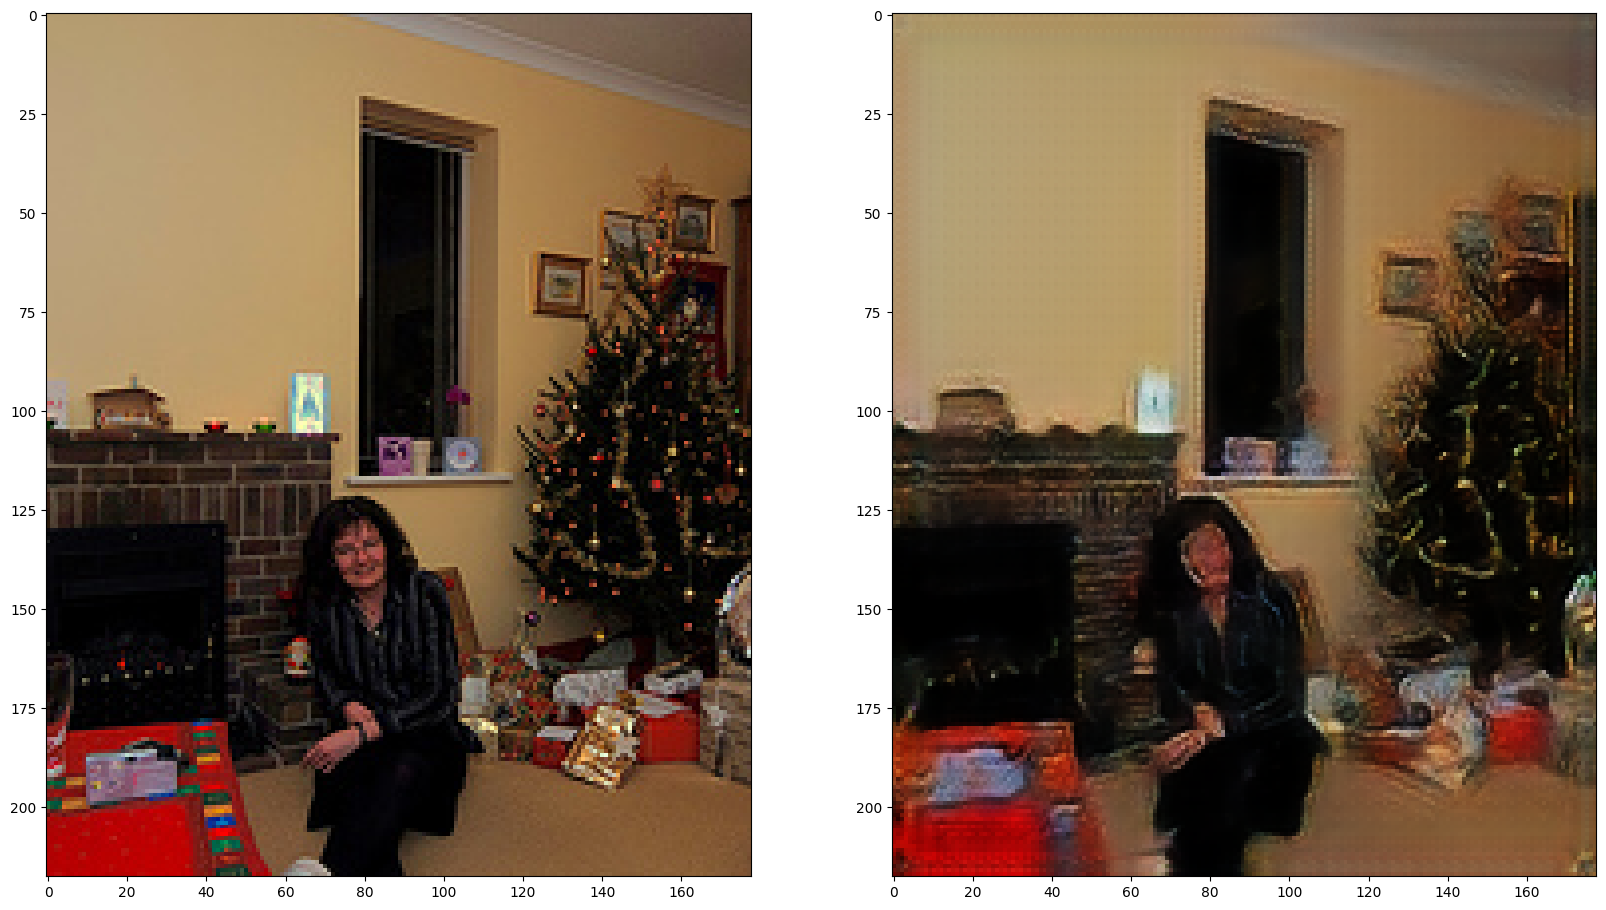

[6/7][1050/1272]	Loss_D: 1.2876	Loss_G: 1.1850	Loss_E: 1.1839	D(x): 0.5695	D(G(z)): 0.4915 / 0.4694
[6/7][1100/1272]	Loss_D: 1.3410	Loss_G: 1.1615	Loss_E: 1.1641	D(x): 0.5834	D(G(z)): 0.5387 / 0.5020
[6/7][1150/1272]	Loss_D: 1.3522	Loss_G: 1.1182	Loss_E: 1.1291	D(x): 0.4884	D(G(z)): 0.4625 / 0.4785
[6/7][1200/1272]	Loss_D: 1.3458	Loss_G: 1.1542	Loss_E: 1.1551	D(x): 0.5410	D(G(z)): 0.5082 / 0.4770
[6/7][1250/1272]	Loss_D: 1.3367	Loss_G: 1.1574	Loss_E: 1.1679	D(x): 0.5154	D(G(z)): 0.4763 / 0.4734


In [ ]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
E_losses = []
iters = 0
num_epochs = 7

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (images) in enumerate(dataloader, 0):
        netG.train()
        netD.train()
        netE.train()

        netD.zero_grad()

        images = images.to(device)
        fake_images = netG(netE(images))

        # (1) Update D network: maximize the Gradient

        ## Create a fake pair batch --

        inp_x = {}
        inp_x['img']=images
        inp_x['encoded'] = netE(images)

        label = torch.FloatTensor(np.random.uniform(low=0.855, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward(retain_graph=True)
        D_x = output.mean().item()

        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)
        label = torch.FloatTensor(np.random.uniform(low=0.005, high=0.155, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward(retain_graph=True)
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake

        optimizerD.step()

        # (2) Update G network: maximize log(D(G(z)))
        netG.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)

        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)

        errG = criterion(output, label) + 4*l1criterion(images,fake_images)
        errG.backward(retain_graph=True)
        D_G_z2 = output.mean().item()
        optimizerG.step()


        netE.zero_grad()
        inp_x_fake = {}
        inp_x_fake['img']=fake_images
        inp_x_fake['encoded'] = netE(images)

        label = torch.FloatTensor(np.random.uniform(low=0.895, high=0.999, size=(images.size(0)))).to(device)
        output = netD(inp_x_fake).view(-1)

        errE = criterion(output, label) + 4*l1criterion(images,fake_images)
        errE.backward(retain_graph=True)
        E_G_z2 = output.mean().item()
        optimizerE.step()

        #STATS
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tLoss_E: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(),errE.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        E_losses.append(errE.item())

        # Check how the generator is doing by saving G's output on fixed_noise

        del images
        del inp_x_fake
        del inp_x
        del label
        del output
        torch.cuda.empty_cache()
        iters += 1


        # Plot the images every 500 iterations
        if i%500 ==0:
            netE.eval()
            netG.eval()
            encoded_img = netE(valid_batch)
            reconstructed_img = netG(encoded_img)
            f, axarr = plt.subplots(num_images_to_show,2)
            for i in range(num_images_to_show):
                validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
                rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5 ) + 0.5
                axarr[0].imshow(validimg)
                axarr[1].imshow(rec_img)
                f.set_figheight(20)
                f.set_figwidth(20)
            plt.show()

In [ ]:
print("Evaluating the model ...")
netE.eval()
netG.eval()
tot_img_size = IMG_WIDTH * IMG_HEIGHT * 3

In [ ]:
valid_dataset = ImageData(is_train=False)
batch_size=20
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
valid_batch = next(iter(valid_dataloader)).to(device)

In [ ]:
print(valid_batch.shape)
encoded_img = netE(valid_batch)
print(encoded_img.shape)
reconstructed_img = netG(encoded_img)
print(reconstructed_img.shape)

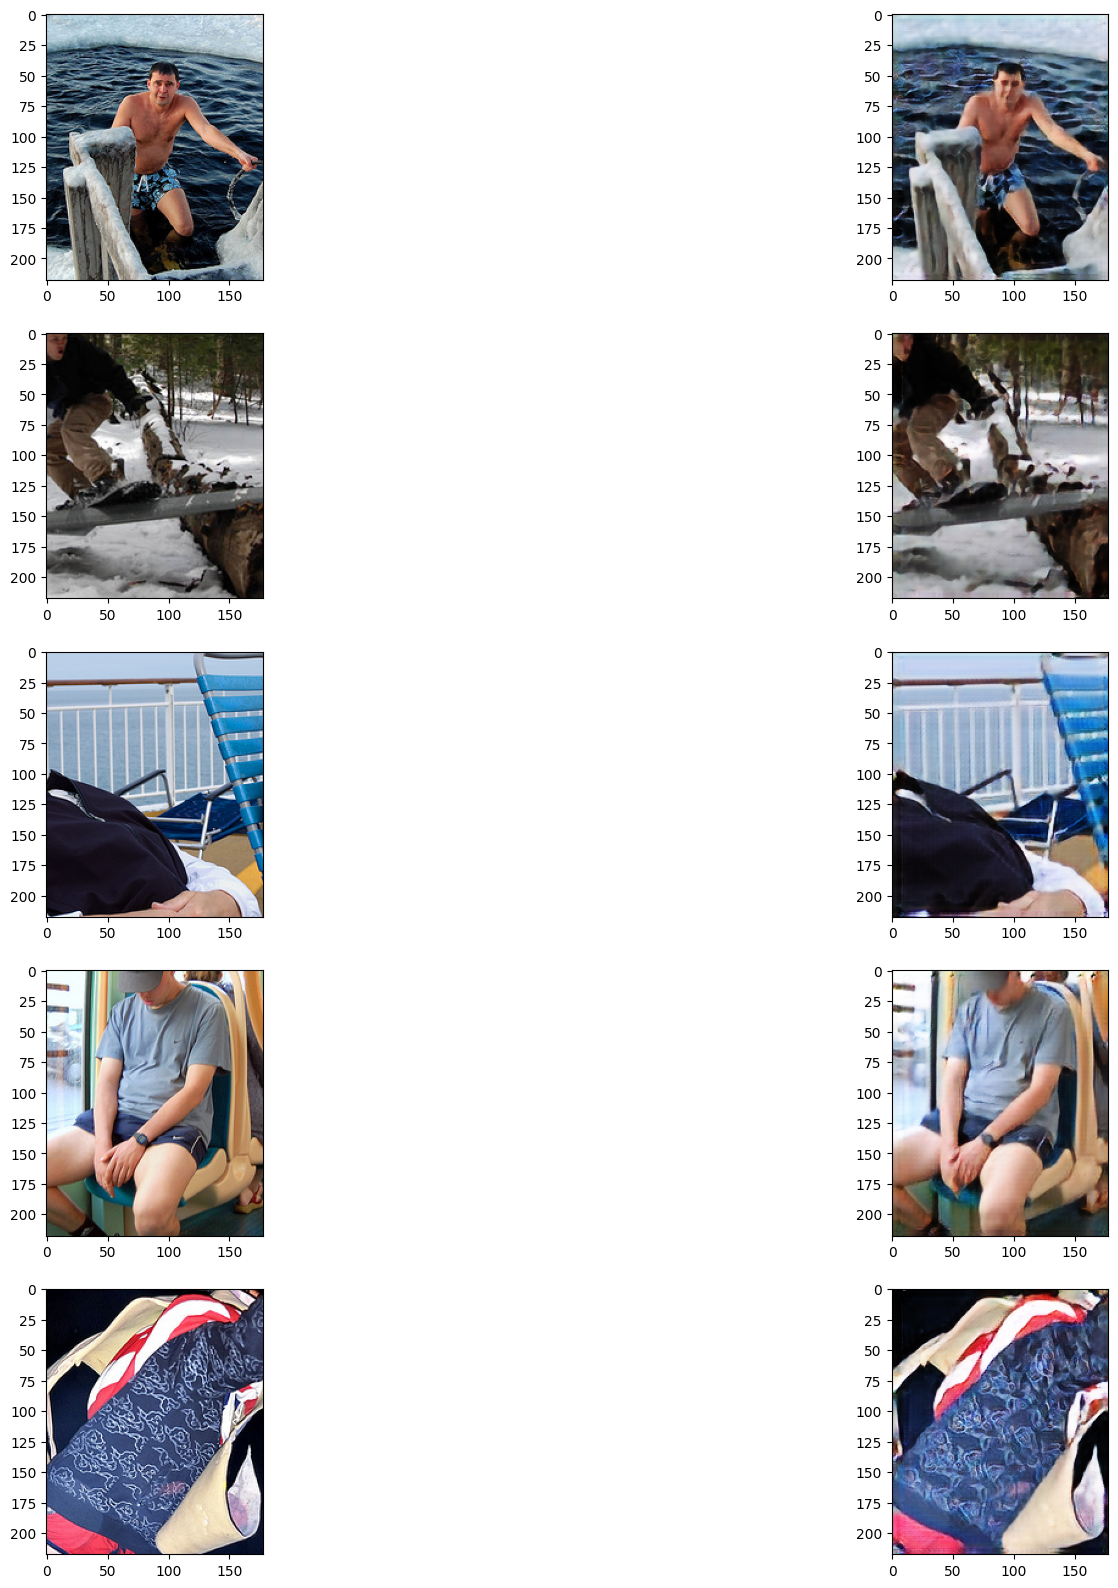

In [ ]:
num_images_to_show = 5
f, axarr = plt.subplots(num_images_to_show,2)
for i in range(num_images_to_show):
    validimg = (valid_batch[i].cpu().detach().permute(1, 2, 0) * 0.5) + 0.5
    rec_img = (reconstructed_img[i].cpu().detach().permute(1, 2, 0) *0.5) + 0.5
    axarr[i,0].imshow(validimg)
    axarr[i,1].imshow(rec_img)
    f.set_figheight(20)
    f.set_figwidth(20)
plt.show()

In [ ]:
torch.save(netE.state_dict(), "netE"+str(num_channels_in_encoder)+".model")
torch.save(netG.state_dict(), "netG"+str(num_channels_in_encoder)+".model")

In [ ]:
print("Total no. of iterations = ",len(E_losses))
print("Mean Encoder loss = ",np.mean(E_losses))
print("Mean Generator loss = ",np.mean(G_losses))
print("Mean Discriminator loss = ",np.mean(D_losses))
print(G_losses)

Total no. of iterations =  8904
Mean Encoder loss =  1.3548900038740277
Mean Generator loss =  1.354852327887849
Mean Discriminator loss =  1.3608441427216162
[2.8520102500915527, 2.811297655105591, 2.808164358139038, 2.710390090942383, 2.8134751319885254, 2.8138928413391113, 2.735395908355713, 2.5188510417938232, 2.2628817558288574, 2.286593437194824, 2.7024970054626465, 2.147242784500122, 2.437692403793335, 2.2158350944519043, 2.3304686546325684, 2.287670135498047, 2.3353166580200195, 2.5334863662719727, 2.1186764240264893, 2.036623954772949, 1.952386498451233, 1.956181526184082, 2.023499011993408, 2.455545425415039, 2.0463576316833496, 2.1192312240600586, 1.9831340312957764, 1.932905673980713, 1.8231881856918335, 1.8632397651672363, 1.7773181200027466, 2.0633325576782227, 1.9984962940216064, 1.970869541168213, 1.8284964561462402, 1.9193568229675293, 1.827509880065918, 1.7608063220977783, 1.7696560621261597, 1.7108726501464844, 2.1548900604248047, 1.8449969291687012, 1.83009755611419

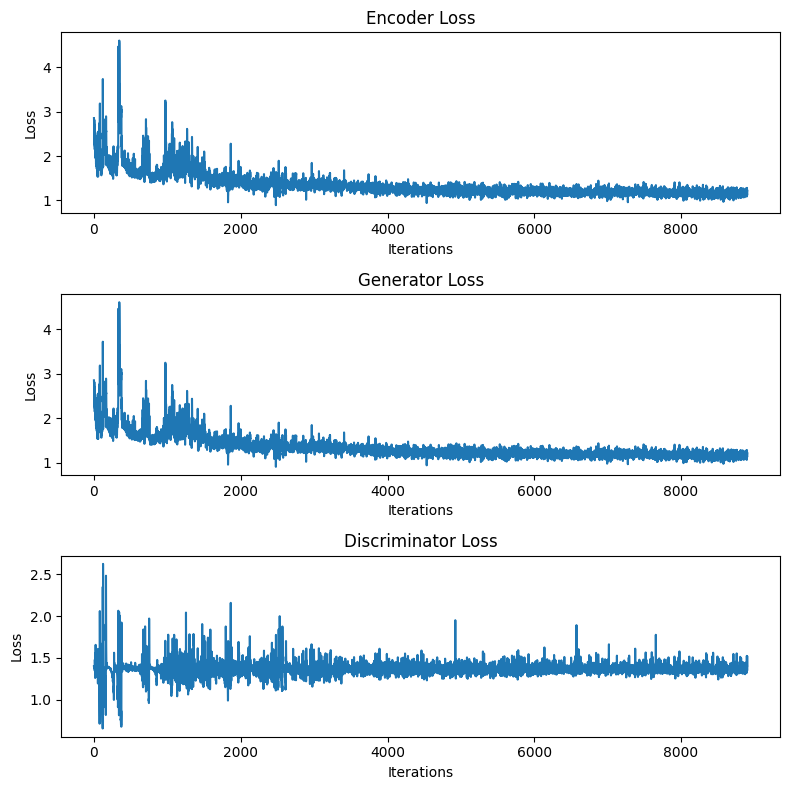

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

ax1.plot(E_losses)
ax1.set_title('Encoder Loss')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')

ax2.plot(G_losses)
ax2.set_title('Generator Loss')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')

ax3.plot(D_losses)
ax3.set_title('Discriminator Loss')
ax3.set_xlabel('Iterations')
ax3.set_ylabel('Loss')


plt.tight_layout()
plt.show()